# Summary

Dans ce notebook, nous allons mettre en pratique un modèle deep learning qui va permettre la détection de la race d'un chien.

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
cd 'drive/MyDrive/stanford_dogs_classification'

/content/drive/.shortcut-targets-by-id/1TtrLnS9Z6sZ3nOvtdyiq4WyUBW83jwkU/stanford_dogs_classification


# Librairies

In [ ]:
%pip install loguru mlflow keras_tuner pendulum python-dotenv pyngrok pydantic==1.10 optuna

In [4]:
%reload_ext autoreload
%autoreload 2


import cv2 as cv
from dotenv import load_dotenv
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras.utils import img_to_array, array_to_img
import keras_tuner as kt
from loguru import logger
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import mlflow
import mlflow.tensorflow
import numpy as np
import optuna
import os
import pendulum
from pathlib import Path
from pyngrok import ngrok
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import sys
sys.path.append(str(Path.cwd().parent))
from settings.params import *

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, Metric
from tensorflow.keras.models import Sequential


import timeit

In [5]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#### Chargement des données

- Liste des races disponibles

In [12]:
EXECUTION_DATE = pendulum.now(tz=TIMEZONE)
logger.info("Execution date: {}",EXECUTION_DATE)
logger.info("\nData input directory : {}\nData output directory: {}",DATA_DIR_INPUT,DATA_DIR_OUTPUT)

2023-08-22 14:51:29.005 | INFO     | __main__:<cell line: 2>:2 - Execution date: 2023-08-22T14:51:29.005752+00:00
2023-08-22 14:51:29.010 | INFO     | __main__:<cell line: 3>:3 - 
Data input directory : /content/drive/.shortcut-targets-by-id/1TtrLnS9Z6sZ3nOvtdyiq4WyUBW83jwkU/stanford_dogs_classification/data/input
Data output directory: /content/drive/.shortcut-targets-by-id/1TtrLnS9Z6sZ3nOvtdyiq4WyUBW83jwkU/stanford_dogs_classification/data/output


In [5]:
annotations_dir = 'data/inputs/Annotation'
images_dir = 'data/inputs/Images'

In [6]:
breed_list = os.listdir(images_dir)
logger.info("Number of breeds in dataset: {}", (len(breed_list)))

2023-08-22 19:52:25.134 | INFO     | __main__:<cell line: 2>:2 - Number of breeds in dataset: 120


IL existe 120 races de chiens dinstinctes dans notre jeu de données. Donc on aura 120 classes différentes pour notre classification.
Essayons de voir si la distribution d'images dans nos classes est assez équitables.

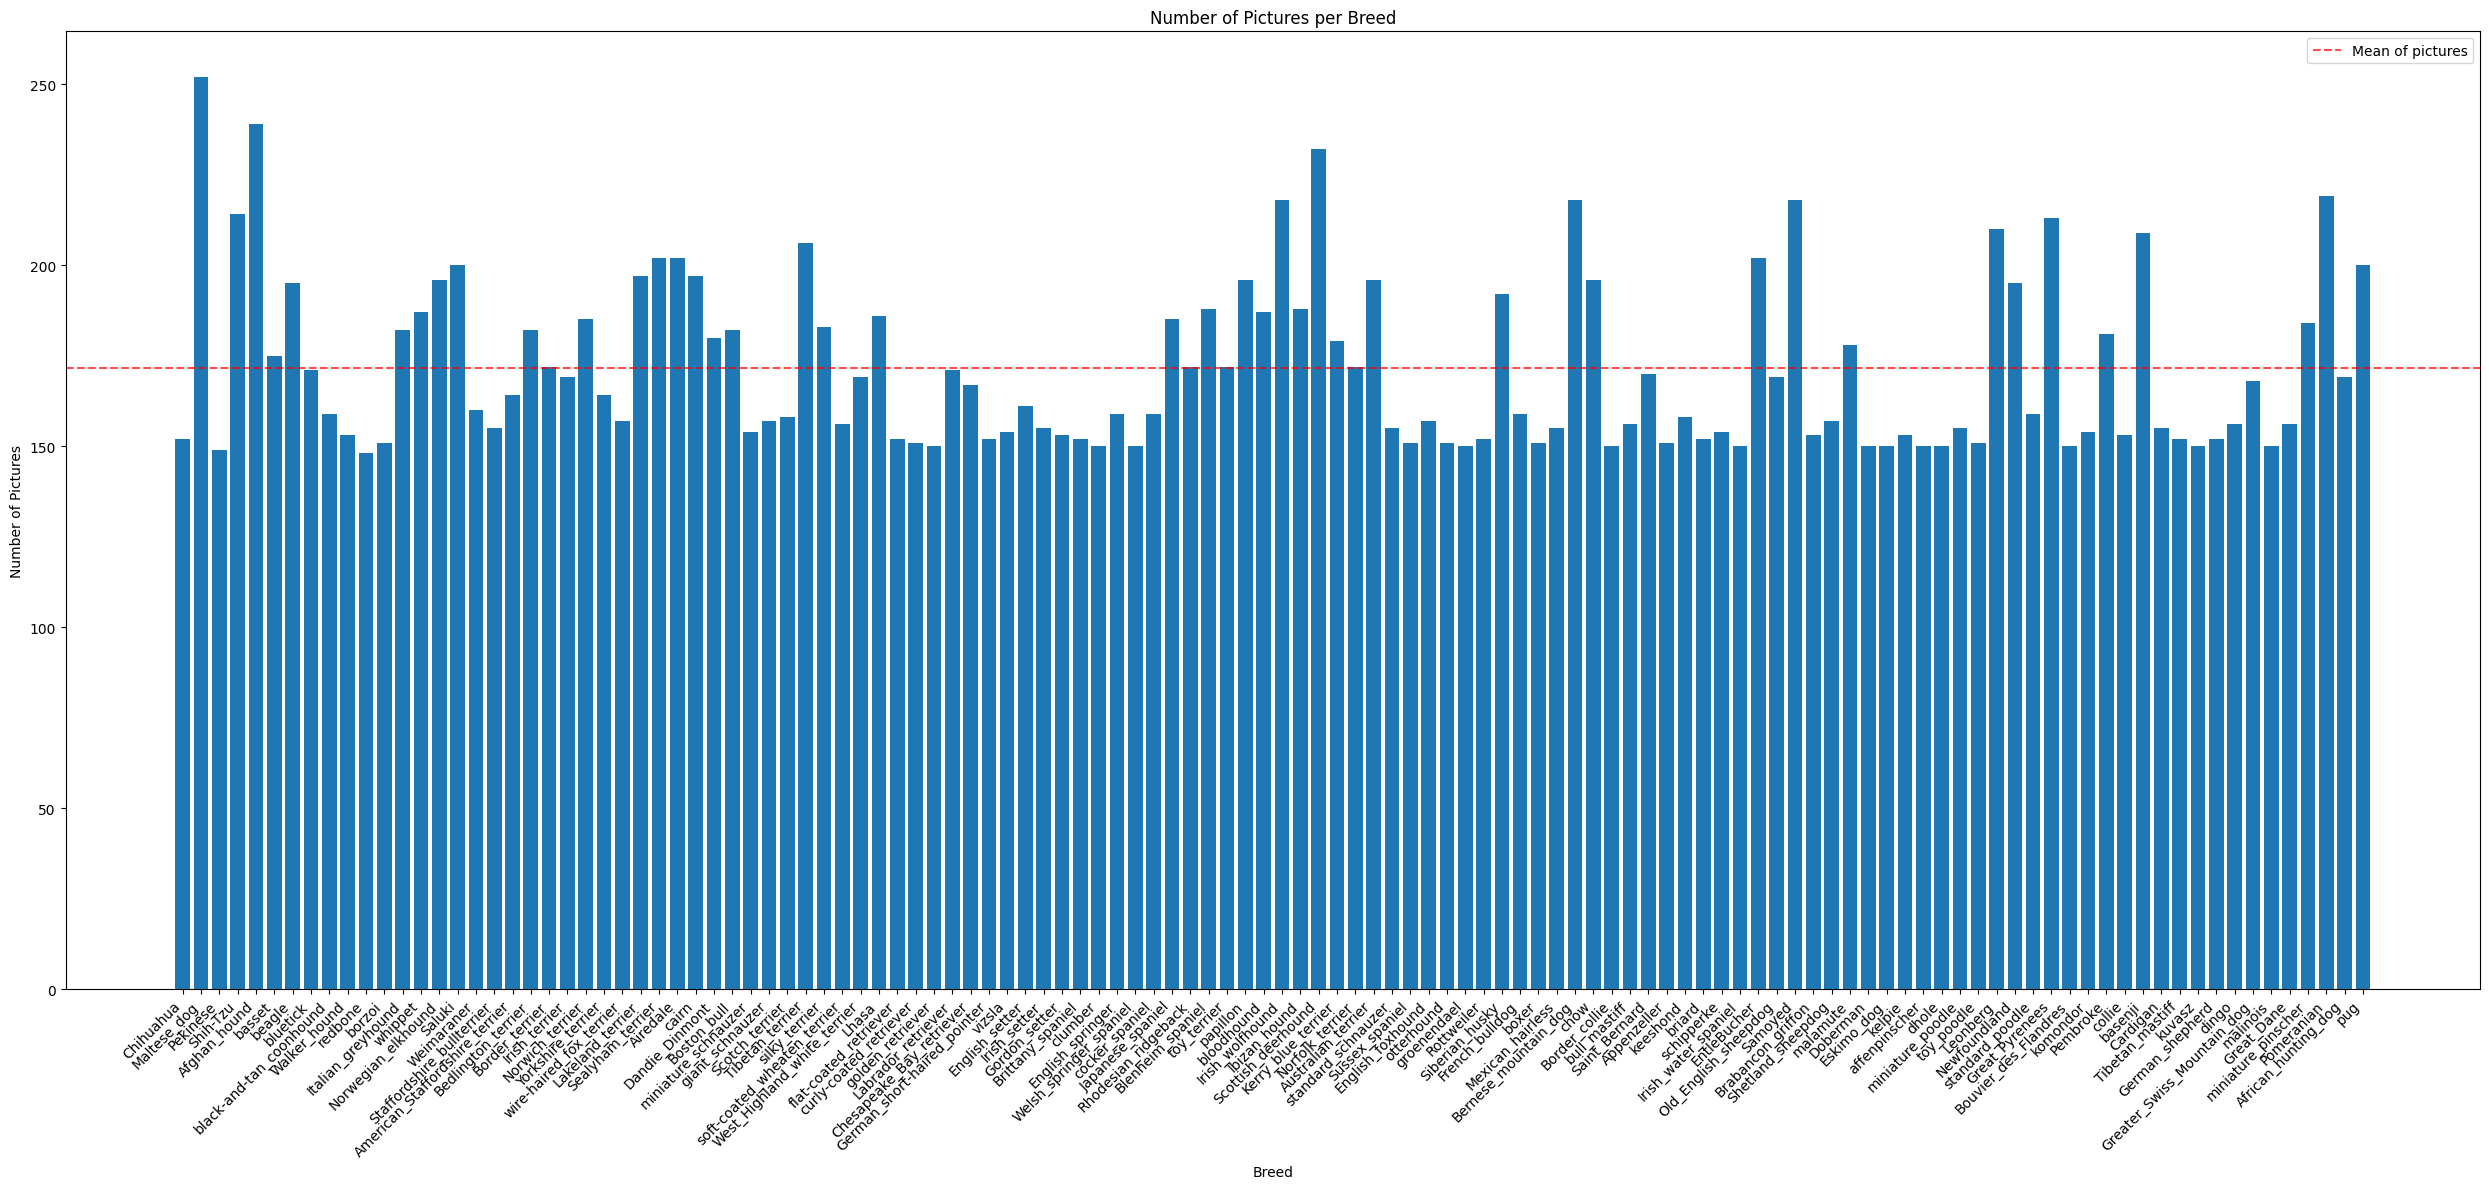

In [7]:
# Count images for each breed
breed_list[0].split('-')[1]
breed_names = [breed.split('-',1)[1] for breed in breed_list]
num_images = [len(os.listdir(images_dir+"/"+(breed))) for breed in breed_list]

plt.figure(figsize=(25, 12))
ax = plt.gca()  # Get the current Axes object

plt.bar(breed_names, num_images)
plt.xlabel("Breed")
plt.ylabel("Number of Pictures")
plt.title("Number of Pictures per Breed")
plt.xticks(rotation=45, ha="right")

# Add the mean line
mean_num_pictures = sum(num_images) / len(num_images)
ax.axhline(mean_num_pictures, color='r', alpha=0.7, linestyle='--', label="Mean of pictures")

plt.legend()
plt.tight_layout()
plt.show()

D'après la figure ci-dessus on peut voir qu'on a une distribution assez équitable des images dans chaque classe. Dans chaque classe on a minimum 170 images.
Ceci nous permettra de garder toutes les classes pour notre modèle. En effet aucune classe n'est sous-représentée, ce qui nous évidera un modèle biaisé.

Visualisons quelques images de chiens

In [21]:
def show_dogs_images(path, classe, num_sample):
  fig = plt.figure(figsize=(18,18))
  plt.suptitle("{}".format(classe.split("-")[1]), y=.62,color="black", fontsize=22)
  images = os.listdir(path + "/" + classe)[:num_sample]
  for i in range(num_sample):
      img = cv.imread(path+"/"+classe+"/"+images[i])
      plt.subplot(num_sample//5+1, 5, i+1)
      plt.imshow(img)
      plt.axis('off')
  plt.show()

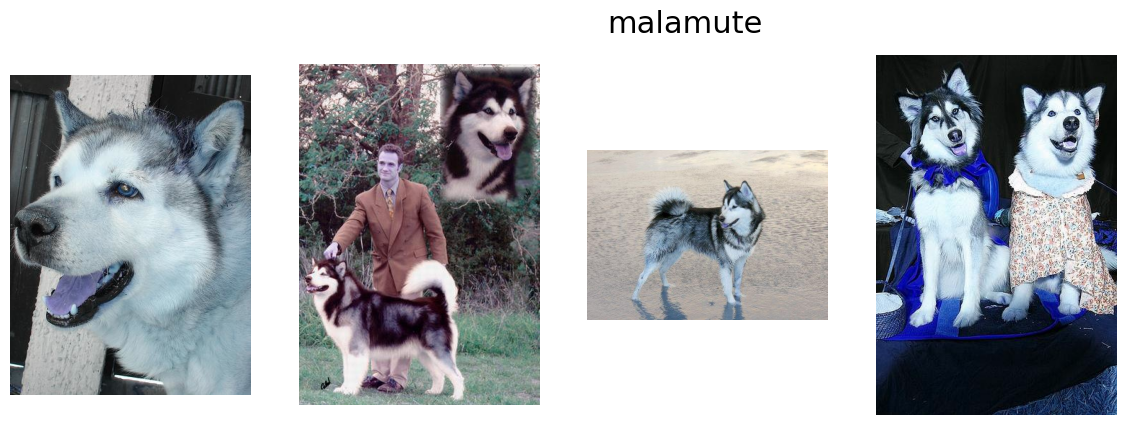

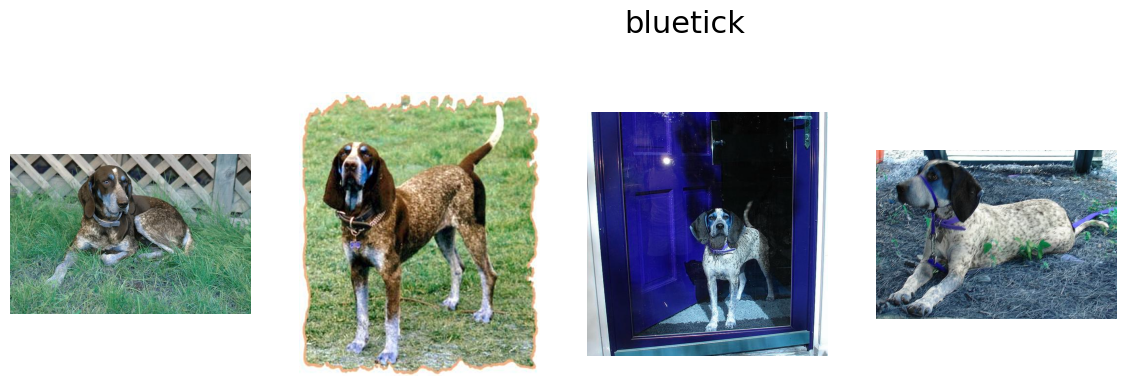

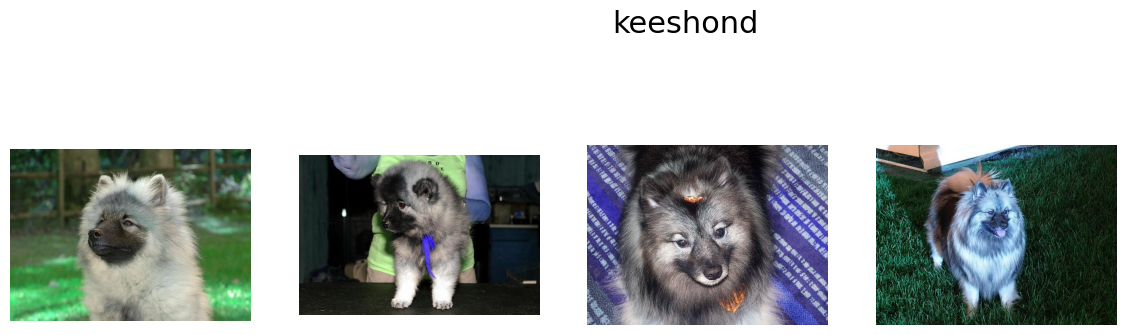

In [22]:
for i in np.random.randint(0, len(breed_list), size=3):
    show_dogs_images(images_dir, breed_list[i], 4)

on peut clairement voir que les images n'ont pas la même taille. Il faudra par conséquent les redimmensionner.
Ceci aura un impact important dans la réduction du temps de calculs dans le model de CNN.

**Modification de la taille des images**

In [23]:
# 224x224: This size is commonly used with architectures like VGG16, VGG19, and ResNet.
# These models were originally trained on the ImageNet dataset using images of this size.
# let's see what is look like using in a random picture
img_test = (images_dir
            + "/"
            + os.listdir(images_dir)[3]+"/"+os.listdir(images_dir+"/"+os.listdir(images_dir)[3])[0])
img_test = cv.imread(img_test)

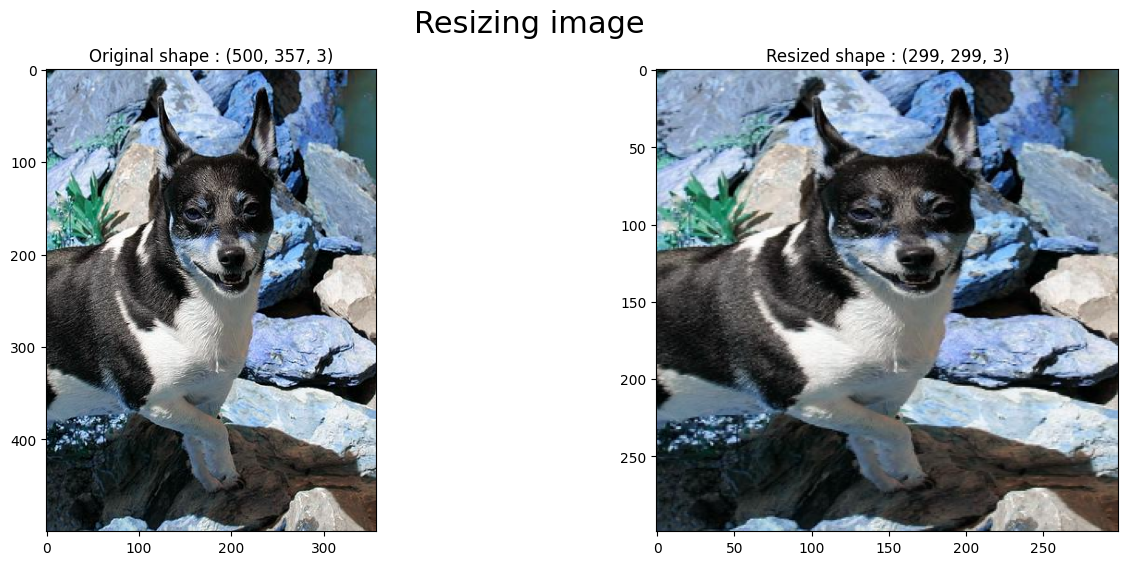

In [24]:
height = 299
width = 299
dim = (width, height)
# resize image with OpenCV
res_img = cv.resize(img_test, dim, interpolation=cv.INTER_LINEAR)

# Show both img
fig = plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.imshow(img_test)
plt.title("Original shape : {}".format(img_test.shape))
plt.subplot(1, 2, 2)
plt.imshow(res_img)
plt.title("Resized shape : {}".format(res_img.shape))
plt.suptitle("Resizing image",
             color="black",
             fontsize=22, y=.98)
plt.show()

ON peut bien voir que le redimensionnement déforme beaucoup l'image initiale. Toutes les images du jeu de données seront donc déformées en appliquant ce redimensionnement.

**Prétraitement basé sur les histogrammes :**

Les images dans un ensemble de données peuvent varier en termes d'exposition (luminosité), de contraste et d'autres attributs visuels. Pour s'assurer que les images dans l'ensemble de données ont des caractéristiques visuelles cohérentes, des méthodes de prétraitement peuvent être utilisées. Une des approches courantes est basée sur les histogrammes d'images. Un histogramme représente la répartition des valeurs de pixel dans une image. En ajustant les valeurs de pixel à travers l'histogramme, vous pouvez égaliser l'exposition, améliorer le contraste et potentiellement augmenter la qualité visuelle des images.

L'histogramme d'une image numérique est une courbe statistique représentant la répartition de ses pixels selon leur intensité.

Nous allons transformer une image du jeu de données dans différents codages couleurs.

Le système de codage YUV est créé depuis une source RGB. Il est codé en trois composantes : Y représente la *luminance* (informations de luminosité) tandis que les deux autres (U et V) sont des *données de chrominance* (informations de couleur). Ce format nous permet de visualiser au mieux l'histogramme pour les 3 dimensions :

In [25]:
img_RGB = cv.cvtColor(img_test, cv.COLOR_BGR2RGB)
img_grayscale = cv.cvtColor(img_test, cv.COLOR_RGB2GRAY)
img_YUV = cv.cvtColor(img_test,cv.COLOR_BGR2YUV)

In [26]:
def plot_histogram(init_img, convert_img):
    hist, bins = np.histogram(convert_img[1].flatten(), 256, [0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()

    fig, axes = plt.subplots(1, 3, figsize=(25, 6))
    axes[0].imshow(init_img[1])
    axes[0].set_title(f"{init_img[0]} Image", color="#343434")
    axes[1].imshow(convert_img[1])
    axes[1].set_title(f"{convert_img[0]} Image", color="#343434")
    axes[2].plot(cdf_normalized, color='r', alpha=0.7, linestyle='--')
    axes[2].hist(convert_img[1].flatten(), 256, [0, 256])
    axes[2].set_xlim([0, 256])
    axes[2].legend(('cdf', 'histogram'), loc='upper left')
    axes[2].set_title("Histogram of converted image", color="#343434")

    plt.suptitle("Histogram and cumulative distribution for test image", color="black", fontsize=22, y=0.98)
    plt.show()

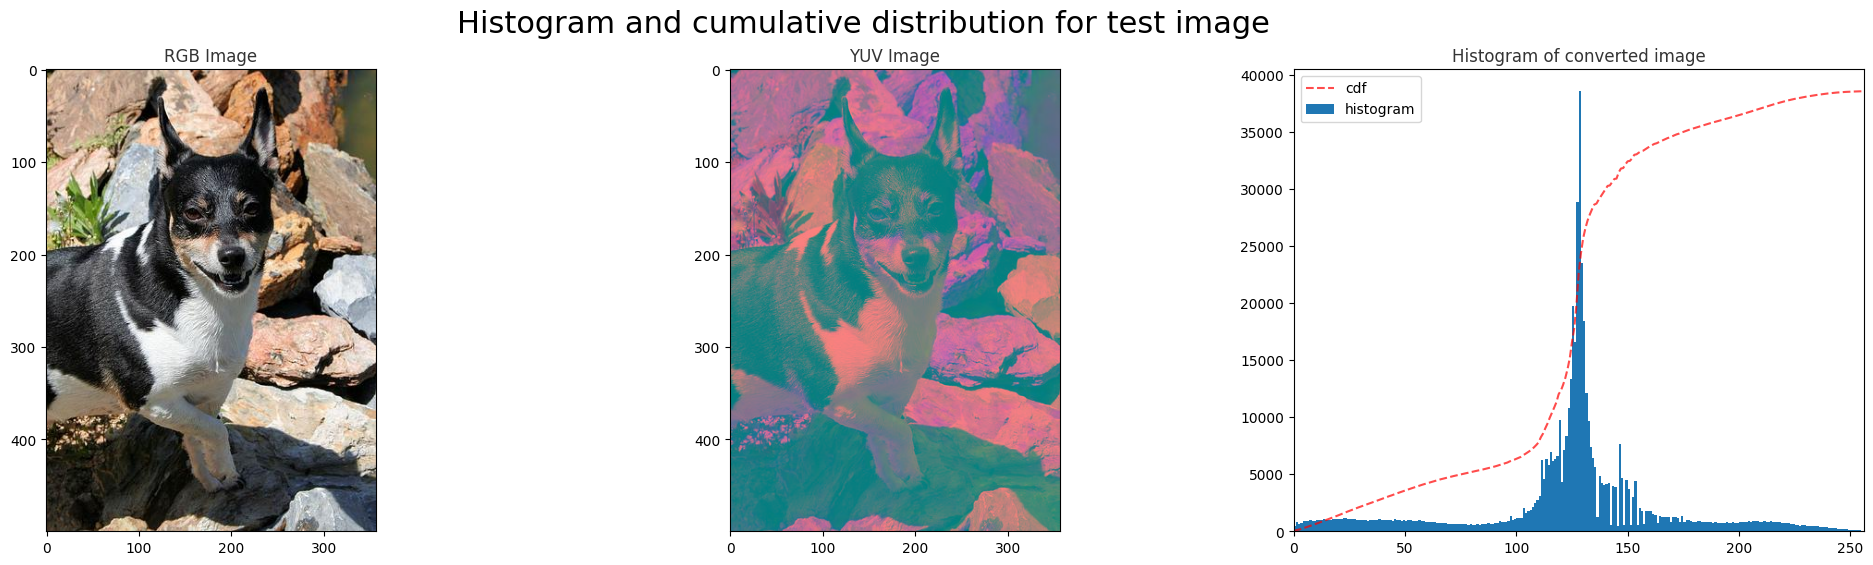

In [27]:
plot_histogram(["RGB", img_RGB], ["YUV", img_YUV])

On constate des pics très importants au mileu de l'histogramme, donc il y'a un problème de contraste. Pour améliorer le contraste, on peut faire l'agalisation c’est-à-dire redistribuer uniformément la luminosité sur l'ensemble du spectre de l'image.

**Egalisation**

On va s'interesser ici unquement au canal "Y" correspondant à la luminosité du YUV.

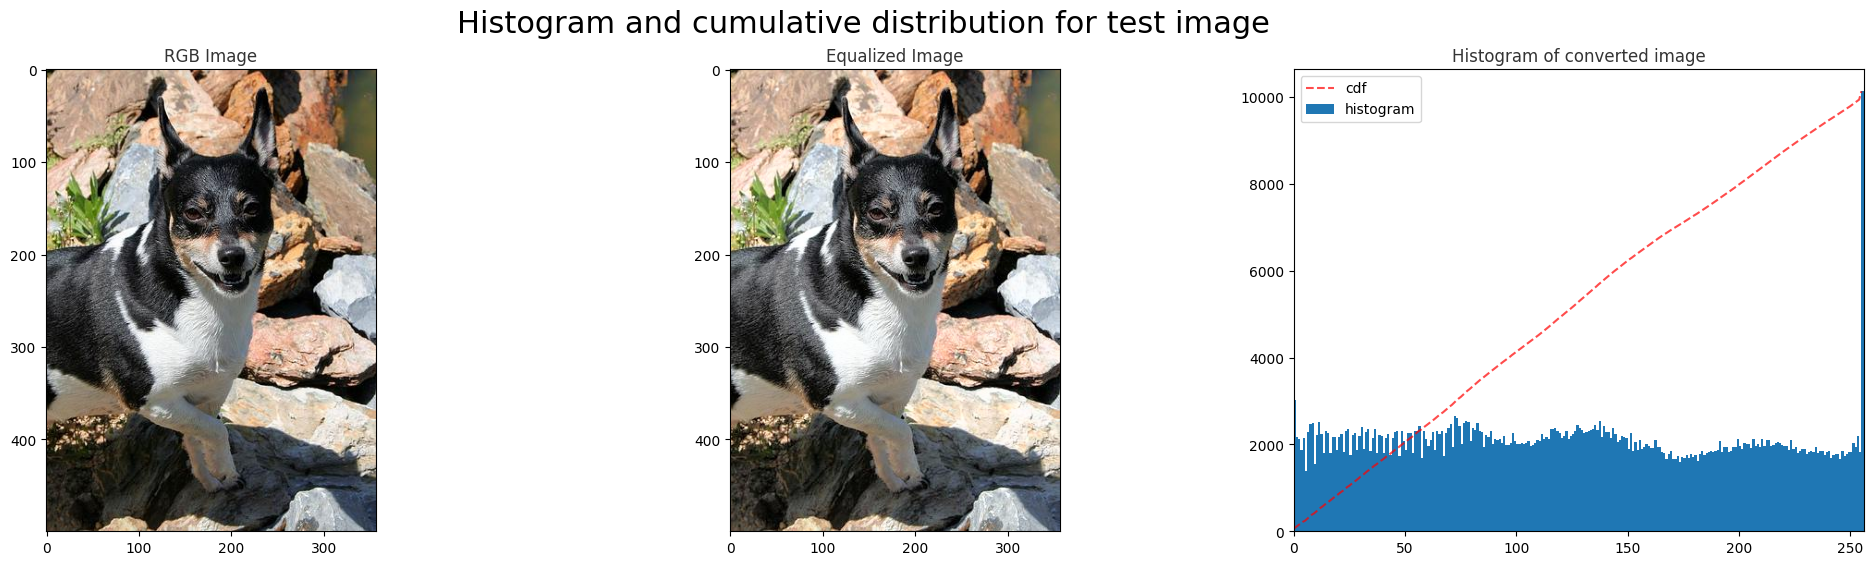

In [28]:
# Equalization
img_YUV[:,:,0] = cv.equalizeHist(img_YUV[:,:,0])
img_equ = cv.cvtColor(img_YUV, cv.COLOR_YUV2RGB)
plot_histogram(["RGB", img_RGB], ["Equalized", img_equ])

L'image résultante est donc bien égualiséeetla CDF est constante et linéaire. Ce qui signifie que l'ensemble des niveaux de gris est uniformément réparti.

Ce pré-traitement pourra donc être appliqué à l'ensemble des images.

**Filtres**

Les images peuvent être bruitées par diverses sources telles que: les propriétés de l'appareil photo, la compression JPEG ou une mauvaise résolution, etc.

Pour remédier au bruit présent dans les images, il est possible d'appliquer un filtre. Il en existe plusieurs types : les filtres linéaires, comme le filtre Gaussien, et les filtres non linéaires, comme le filtre médian,etc.
Un des meilleurs filtre pour débruiter l'image est le filtre non-local means.

En effet, Le filtre non-local means diffère des filtres de moyenne locale en ce sens qu'il n'utilise pas seulement les pixels voisins pour lisser l'image. Au lieu de cela, il prend en compte tous les pixels de l'image, en utilisant leur similarité avec le pixel cible pour calculer une moyenne pondérée. Cette approche offre un lissage post-filtrage plus net et conserve davantage de détails dans l'image par rapport aux méthodes traditionnelles de moyenne locale.


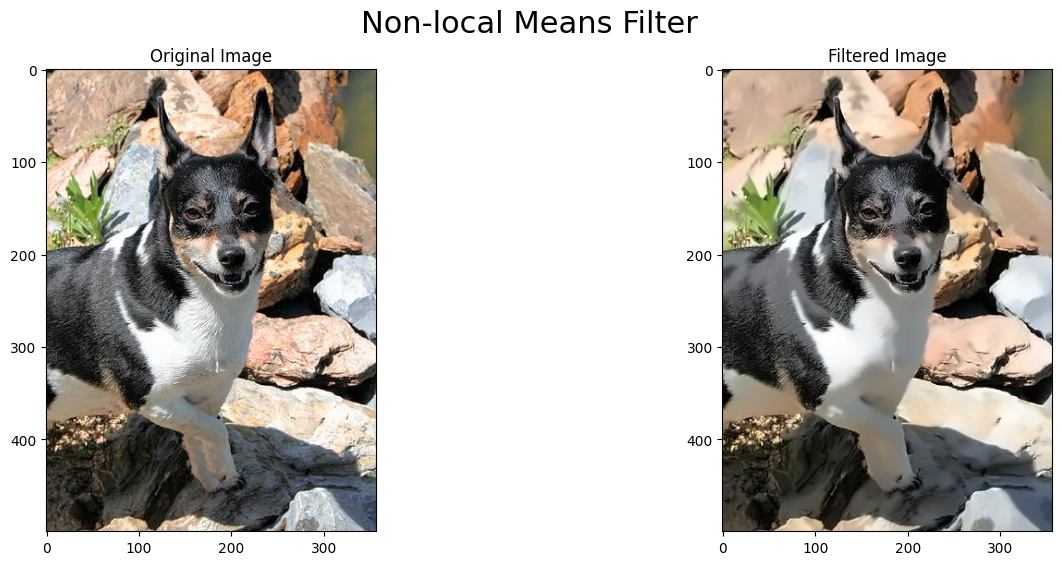

In [29]:
# Apply non-local means filter on test img
dst_img = cv.fastNlMeansDenoisingColored(
    src=img_equ,
    dst=None,
    h=10,
    hColor=10,
    templateWindowSize=7,
    searchWindowSize=21)

# Show both img
fig = plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.imshow(img_equ)
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(dst_img)
plt.title("Filtered Image")
plt.suptitle("Non-local Means Filter",
             color="black",
             fontsize=22, y=.98)
plt.show()

In [9]:
def preprocessing_cnn(directories, img_width, img_height):
  img_list=[]
  labels=[]
  for index, breed in enumerate(directories):
    for image_name in os.listdir(images_dir+"/"+breed):
      # Read image
      img = cv.imread(images_dir+"/"+breed+"/"+image_name)
      img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
      # Resize image
      dim = (img_width, img_height)
      img = cv.resize(img, dim, interpolation=cv.INTER_LINEAR)
      # Equalization
      img_yuv = cv.cvtColor(img,cv.COLOR_BGR2YUV)
      img_yuv[:,:,0] = cv.equalizeHist(img_yuv[:,:,0])
      img_equ = cv.cvtColor(img_yuv, cv.COLOR_YUV2RGB)
      # Apply non-local means filter on test img
      dst_img = cv.fastNlMeansDenoisingColored(
          src=img_equ,
          dst=None,
          h=10,
          hColor=10,
          templateWindowSize=7,
          searchWindowSize=21)
      # Convert modified img to array
      img_array = img_to_array(dst_img)
      # Append lists of labels and images
      img_list.append(np.array(img_array))
      labels.append(breed.split("-")[1])

  return img_list, labels

In [10]:
#On va tester le model CNN sur une quinzaine de classes avant de généraliser sur toutes les classes si c'est satisfaisant
test_breed_list = random.sample(breed_list,15)

In [11]:
# Define numbers of breeds to preprocess
num_breeds = len(test_breed_list)

# Execute preprocessor on selection
start_time = timeit.default_timer()
# X = images
# y = labels
X, y = preprocessing_cnn(test_breed_list, 299, 299)
# Convert in numpy array
X = np.array(X)
y = np.array(y)

In [12]:
logger.info("Execution time for preprocessing :")
logger.info("Number of images preprocessed : {}"\
     .format(len(y)))
logger.info("Shape of images np.array : {}"\
     .format(X.shape))
logger.info("Total time : {:.2f}s".format(timeit.default_timer() - start_time))

2023-08-22 20:08:58.402 | INFO     | __main__:<cell line: 1>:1 - Execution time for preprocessing :
2023-08-22 20:08:58.405 | INFO     | __main__:<cell line: 2>:2 - Number of images preprocessed : 2668
2023-08-22 20:08:58.407 | INFO     | __main__:<cell line: 4>:4 - Shape of images np.array : (2668, 299, 299, 3)
2023-08-22 20:08:58.408 | INFO     | __main__:<cell line: 6>:6 - Total time : 872.82s


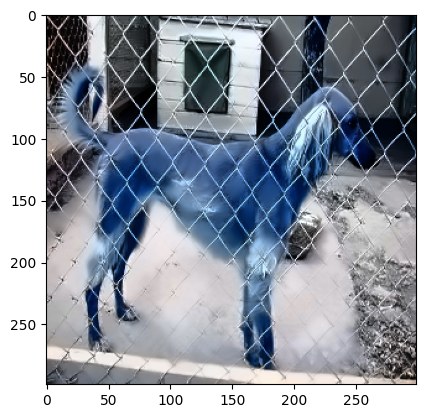

In [34]:
plt.imshow(array_to_img(X[1325]))

#### Modeling
1. Model CNN from scratch:
  - Préparation des données: après notre préprocessing qui consistait à l'égalisation, lé débruitage et le redimensionnement des images, nous allons les numériser en créant des listes Numpy.
  Nous allons ensuite encoder nos classes avec LabelEncoder. En effet elles sont textuelles et on a besoin de les convertir en format numérique pour le modèle.
  

Les images sont organisées en classe. Donc, toutes les images d'une même catégorie se suivent. Ce qui peut biaiser un peu. Pour éviter cela, nous allons mélanger les données.

In [13]:
#indexing
img_space = np.arange(X.shape[0])
#maintaining the same results
np.random.seed(8)
# Shuffling
np.random.shuffle(img_space)
# Apply to X and y
X = X[img_space]
y = y[img_space]

In [14]:
# Change X type
X = X.astype(np.float32)
# Encode y text data in numeric
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [17]:
# save classes
np.save(os.path.join(MODEL_DIR,'encoder_classes.npy'), y)

In [37]:
logger.info("les classes numérisées: {}",y)

2023-08-22 15:06:31.754 | INFO     | __main__:<cell line: 1>:1 - les classes numérisées: [14  6 14 ...  8  7 14]


In [38]:
logger.info("Encoder classes: {}",encoder.classes_)

2023-08-22 15:06:36.472 | INFO     | __main__:<cell line: 1>:1 - Encoder classes: ['Brabancon_griffon' 'Greater_Swiss_Mountain_dog' 'Ibizan_hound'
 'Kerry_blue_terrier' 'Lakeland_terrier' 'Newfoundland' 'Rottweiler'
 'Saluki' 'Shetland_sheepdog' 'Shih' 'Siberian_husky' 'malamute'
 'otterhound' 'silky_terrier' 'standard_schnauzer']


Toujours dans la préparation, nous pouvons subdiviser les données en sets d'entrainement et de test qui serviront à l'entrainement de nos modèles. Le set de validation quant à lui sera créé directement dans le générateur Keras.*texte en italique*

In [39]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

logger.info("Size of created sets :")
logger.info("Train set size = {}",x_train.shape[0])
logger.info("Test set size = {}",x_test.shape[0])

2023-08-22 15:06:52.690 | INFO     | __main__:<cell line: 3>:3 - Size of created sets :
2023-08-22 15:06:52.694 | INFO     | __main__:<cell line: 4>:4 - Train set size = 1690
2023-08-22 15:06:52.698 | INFO     | __main__:<cell line: 5>:5 - Test set size = 423


La dernière étape de la préparation consiste à l'augmentation des données du jeu d’entraînement en utilisant les générateurs de Keras.

In [40]:
# Validation set is define here
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

#For validation and test, just rescale
test_datagen = ImageDataGenerator(rescale=1./255)


  - **Construction du modèle CNN**:
  
  Dans cette section, nous allons créer un premier modèle de réseau de neurones convolutifs en utilisant plusieurs couches :
   - **Couches de convolution** : Elles servent à repérer des caractéristiques spécifiques dans les images. Cela se fait en appliquant un filtre de convolution pour détecter ces caractéristiques.

   - **Couches de Pooling** : Cette opération réduit la taille des images tout en conservant les éléments importants.

   - **Couches de correction ReLU** : Ces couches transforment les valeurs négatives en zéro, agissant ainsi comme une fonction d'activation.

   - **Couches Fully connected** : Elles prennent un vecteur en entrée, le transforment via une combinaison linéaire et éventuellement une fonction d'activation.

   - **DropOut** : Cette technique désactive aléatoirement des sorties de neurones pour éviter le sur-apprentissage.

Pour notre modèle, nous allons utiliser une architecture simple et peu profonde. Cela nous servira de point de départ pour les modèles futurs. Nous allons mettre en place uniquement trois couches de convolution.

En plus de cela, nous allons évaluer notre modèle avec des métriques plus détaillées que la simple précision (*Accuracy*). Par exemple, nous allons utiliser le ***Score F1*** qui combine la *précision* et le rappel *(recall)*.





In [41]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

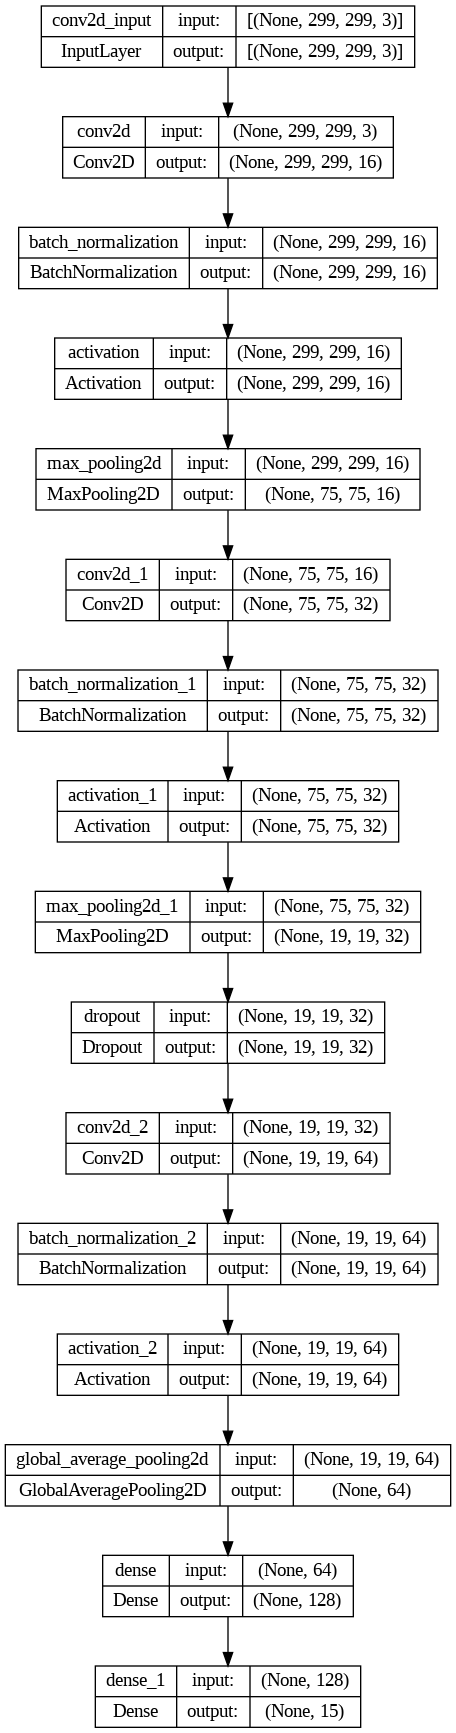

In [61]:
K.clear_session()
model = Sequential()
# Convolution layer
model.add(Conv2D(filters=16,
                 kernel_size=(3,3),
                 padding='same',
                 use_bias=False,
                 input_shape=(299,299,3)))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation('relu'))
# Pooling layer
model.add(MaxPooling2D(pool_size=(4, 4),
                       strides=(4, 4),
                       padding='same'))
# Second convolution layer
model.add(Conv2D(filters=32,
                 kernel_size=(3,3),
                 padding='same',
                 use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.2))
# Third convolution layer
model.add(Conv2D(filters=64,
                 kernel_size=(3,3),
                 padding='same',
                 use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation('relu'))
model.add(GlobalAveragePooling2D())
# Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(num_breeds, activation='softmax'))
plot_model(model, to_file=os.path.join(DATA_DIR_OUTPUT, 'CNN_model_plot.png'),
           show_shapes=True, show_layer_names=True)

In [62]:
# Compile the model
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", f1_m])

In [63]:
history = model.fit(
    train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'),
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    steps_per_epoch=len(x_train) / 32,
    epochs=20,
    verbose=2)

Epoch 1/20
52/52 - 28s - loss: 2.6853 - accuracy: 0.1095 - f1_m: 13.8621 - val_loss: 2.6826 - val_accuracy: 0.1095 - val_f1_m: 16.4618 - 28s/epoch - 524ms/step
Epoch 2/20
52/52 - 25s - loss: 2.5930 - accuracy: 0.1429 - f1_m: 13.1946 - val_loss: 2.6772 - val_accuracy: 0.1095 - val_f1_m: 13.8025 - 25s/epoch - 471ms/step
Epoch 3/20
52/52 - 26s - loss: 2.5668 - accuracy: 0.1452 - f1_m: 12.7255 - val_loss: 2.6661 - val_accuracy: 0.1302 - val_f1_m: 13.9409 - 26s/epoch - 484ms/step
Epoch 4/20
52/52 - 23s - loss: 2.5527 - accuracy: 0.1607 - f1_m: 12.6946 - val_loss: 2.6640 - val_accuracy: 0.1154 - val_f1_m: 12.0932 - 23s/epoch - 436ms/step
Epoch 5/20
52/52 - 28s - loss: 2.5505 - accuracy: 0.1476 - f1_m: 12.3144 - val_loss: 2.7198 - val_accuracy: 0.0828 - val_f1_m: 12.6211 - 28s/epoch - 532ms/step
Epoch 6/20
52/52 - 23s - loss: 2.5011 - accuracy: 0.1686 - f1_m: 11.8847 - val_loss: 2.6866 - val_accuracy: 0.0947 - val_f1_m: 11.8298 - 23s/epoch - 432ms/step
Epoch 7/20
52/52 - 25s - loss: 2.4982 - 

In [58]:
def plot_history_scores(dict_history, first_score, second_score):
    with plt.style.context('seaborn-whitegrid'):
        fig = plt.figure(figsize=(25,10))
        # summarize history for accuracy
        plt.subplot(1, 2, 1)
        plt.plot(dict_history.history[first_score], color="g")
        plt.plot(dict_history.history['val_' + first_score],
                 linestyle='--', color="orange")
        plt.title('Model ' + first_score, fontsize=18)
        plt.ylabel(first_score)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        # summarize history for loss
        plt.subplot(1, 2, 2)
        plt.plot(dict_history.history[second_score], color="g")
        plt.plot(dict_history.history['val_' + second_score],
                 linestyle='--', color="orange")
        plt.title('Model ' + second_score, fontsize=18)
        plt.ylabel(second_score)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

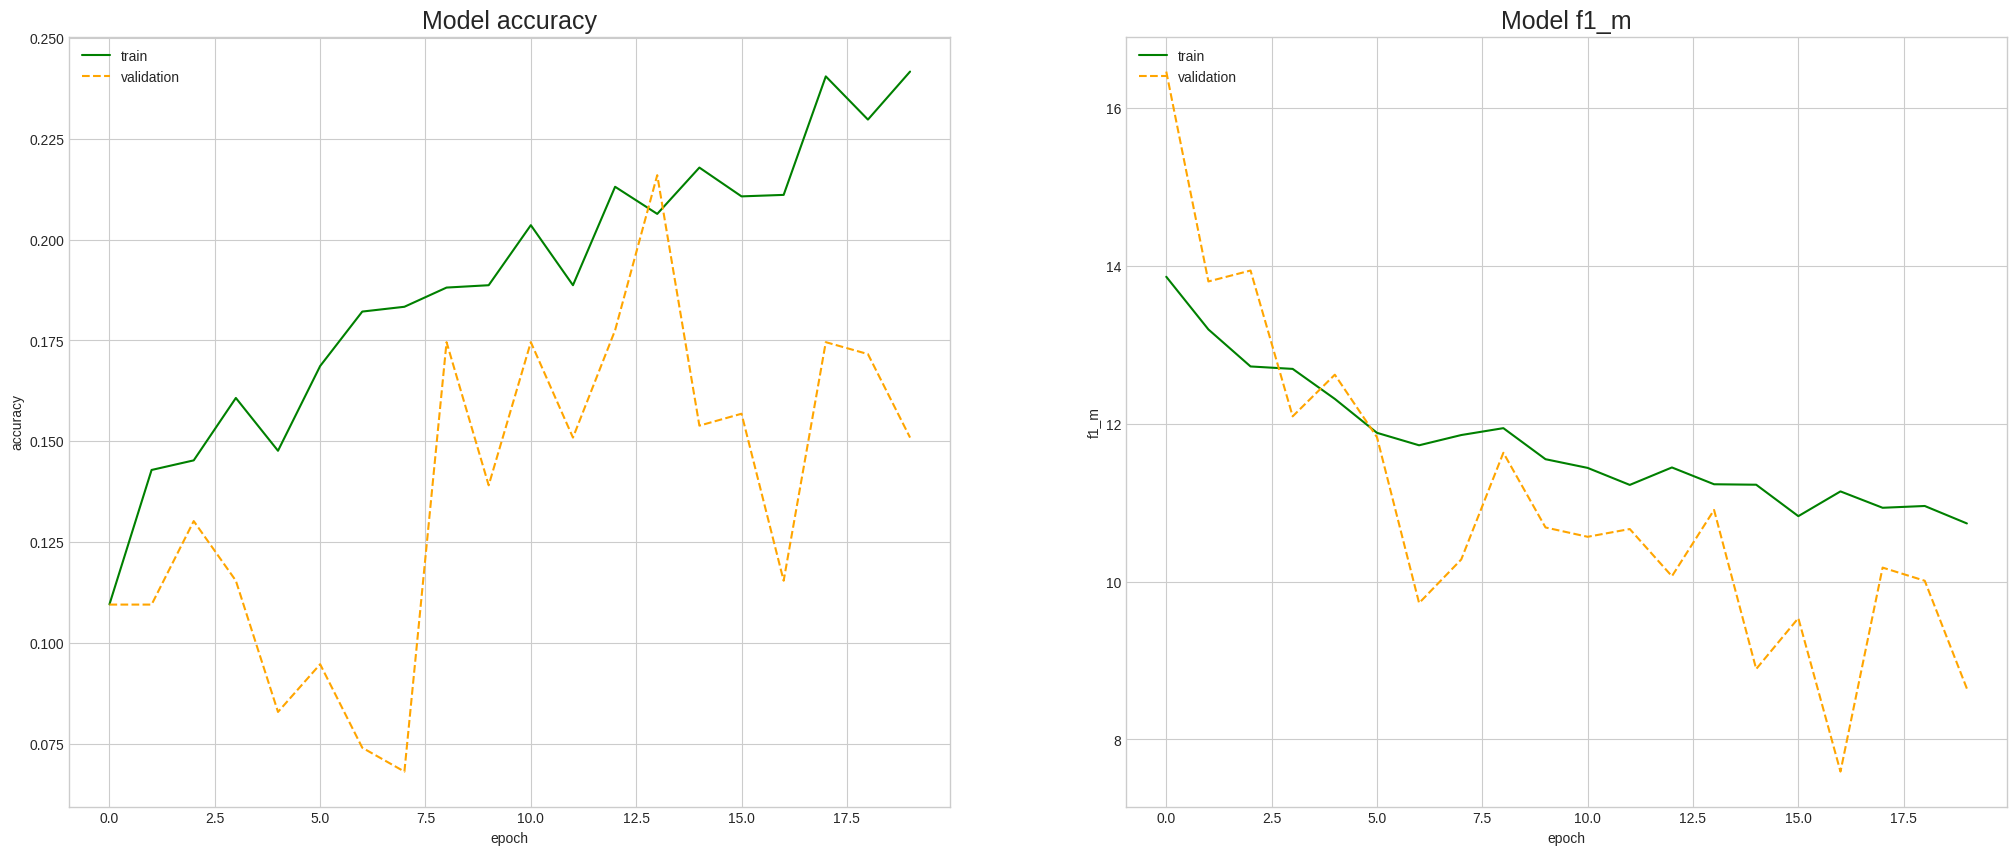

In [64]:
plot_history_scores(
    dict_history = history,
    first_score = "accuracy",
    second_score = "f1_m")

Le modèle de CNN from scratch ne donne pas de bons résultats. En effet, on peut bien voir à travers les courbes d’apprentissage que ***l'accuracy ne dépasse pas 25% et que le F1-Score est très élevé***.

On ne va pas donc pas généraliser sur toutes les classes.

Pour la suite, on va tester les modèles pré-entrainés pour faire du transfert learning, afin de voir si les performances sont meilleures.

**2. Transfert learning**: Le transfert d'apprentissage (transfer learning) est une technique couramment utilisée en apprentissage automatique, notamment pour les tâches de classification d'images. L'utilisation d'une architecture pré-entraînée peut grandement accélérer le processus de développement de modèles performants.

- **Modèle pré-entrainé Xception**: Xception est une architecture de réseau de neurones convolutionnels (CNN) qui a été pré-entraînée sur de vastes jeux de données, tels que ImageNet.

  Le modèle Xception est dérivé de l'architecture Inception. Inception a pour but de réduire la consommation de ressources des CNN profonds.
  
  Ainsi, Xception exploite l'idée d'Inception et introduit des améliorations pour réduire davantage la complexité des réseaux tout en conservant une bonne capacité de représentation des caractéristiques. Cela le rend particulièrement utile pour des tâches de classification d'images où les ressources computationnelles et la vitesse d'entraînement peuvent être des facteurs importants.



Nous allons charger le modèle depuis Keras mais sans les couches fully-connected.
Les couches convolutionnelles d'un modèle pré-entraîné, tel que Xception, ont déjà appris à extraire des caractéristiques générales à partir d'images. Ainsi, en ajoutant nos propres couches fully-connected, nous pouvons exploiter ces caractéristiques pour la tâche spécifique sans avoir à réapprendre l'extraction des caractéristiques.

In [65]:
K.clear_session()
# Import Xception trained model
xception_model = tf.keras.applications.xception.Xception(
    weights='imagenet',
    include_top=False,
    pooling='avg',
    input_shape=(299,299,3))

# look at the differents layers
logger.info("Xception base model layers :")
for layer in xception_model.layers:
    logger.info(layer)

83683744/83683744 [==============================] - 0s 0us/step


2023-08-22 15:38:13.770 | INFO     | __main__:<cell line: 10>:10 - Xception base model layers :
2023-08-22 15:38:13.772 | INFO     | __main__:<cell line: 11>:12 - <keras.engine.input_layer.InputLayer object at 0x78e22721f310>
2023-08-22 15:38:13.775 | INFO     | __main__:<cell line: 11>:12 - <keras.layers.convolutional.conv2d.Conv2D object at 0x78e21c249b70>
2023-08-22 15:38:13.777 | INFO     | __main__:<cell line: 11>:12 - <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x78e3f5affa00>
2023-08-22 15:38:13.779 | INFO     | __main__:<cell line: 11>:12 - <keras.layers.core.activation.Activation object at 0x78e2270c3400>
2023-08-22 15:38:13.781 | INFO     | __main__:<cell line: 11>:12 - <keras.layers.convolutional.conv2d.Conv2D object at 0x78e2270c2b30>
2023-08-22 15:38:13.782 | INFO     | __main__:<cell line: 11>:12 - <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x78e2270c3580>
2023-08-22 15:38:13.784 | INFO     | __main__:<cel

In [66]:
for layer in xception_model.layers:
    layer.trainable = False

In [67]:
# Add new fully-connected layers
base_output = xception_model.output
base_output = Dense(128, activation='relu')(base_output)
base_output = Dropout(0.2)(base_output)
# new classifier
predictions = Dense(num_breeds, activation='softmax')(base_output)

# Define new model
my_xcept_model = Model(inputs=xception_model.input,
                       outputs=predictions)
my_xcept_model.compile(optimizer="adam",
                       loss="sparse_categorical_crossentropy",
                       metrics=["accuracy", f1_m])

In [ ]:
Xception_plot = plot_model(my_xcept_model,
                           to_file=os.path.join(DATA_DIR_OUTPUT,'xcept_model_plot.png'),
                           show_shapes=True,
                           show_layer_names=False)

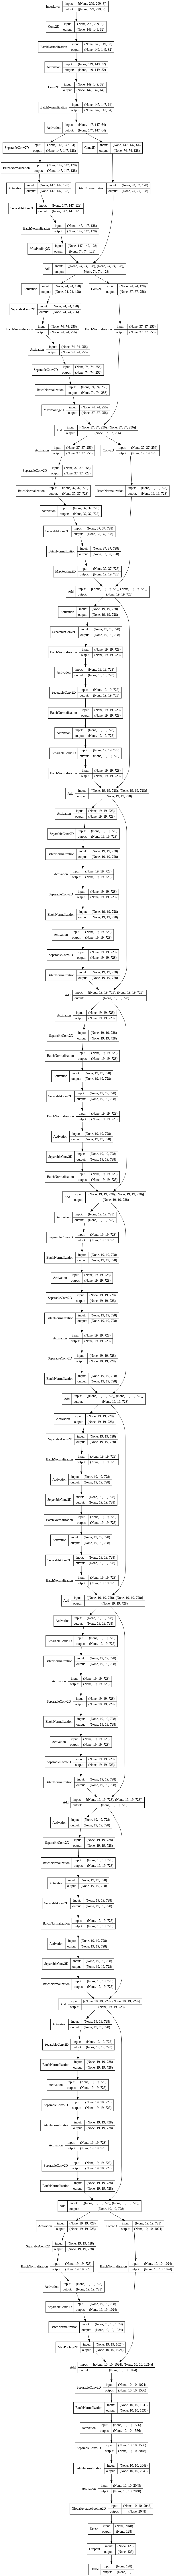

In [ ]:
Xception_plot

Il est également nécessaire de modifier les générateurs pour y intégrer le preprocess_input Xception recommandé par Keras.

Chaque architecture de CNN peut avoir des prétraitements spécifiques recommandés pour maximiser les performances du modèle. Le `preprocess_input` est une fonction fournie par Keras qui effectue un prétraitement spécifique à l'architecture du modèle, comme Xception, afin d'ajuster les valeurs des images d'entrée aux besoins du modèle.

In [68]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function=tf.keras.applications.xception.preprocess_input)

#For validation and test, just rescale
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input)

In [69]:
history_xcept = my_xcept_model.fit(
    train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'),
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    steps_per_epoch=len(x_train) / 32,
    epochs=20,
    verbose=2)

Epoch 1/20
52/52 - 31s - loss: 1.7240 - accuracy: 0.4976 - f1_m: 7.3656 - val_loss: 0.9740 - val_accuracy: 0.7160 - val_f1_m: 3.4300 - 31s/epoch - 591ms/step
Epoch 2/20
52/52 - 27s - loss: 0.9139 - accuracy: 0.7217 - f1_m: 2.9600 - val_loss: 0.7998 - val_accuracy: 0.7456 - val_f1_m: 2.5428 - 27s/epoch - 515ms/step
Epoch 3/20
52/52 - 27s - loss: 0.7789 - accuracy: 0.7619 - f1_m: 2.4617 - val_loss: 0.7272 - val_accuracy: 0.7781 - val_f1_m: 2.4589 - 27s/epoch - 510ms/step
Epoch 4/20
52/52 - 26s - loss: 0.6932 - accuracy: 0.7833 - f1_m: 2.3016 - val_loss: 0.6661 - val_accuracy: 0.7811 - val_f1_m: 2.3598 - 26s/epoch - 502ms/step
Epoch 5/20
52/52 - 29s - loss: 0.6283 - accuracy: 0.7995 - f1_m: 2.1359 - val_loss: 0.6764 - val_accuracy: 0.7840 - val_f1_m: 2.0151 - 29s/epoch - 545ms/step
Epoch 6/20
52/52 - 29s - loss: 0.5607 - accuracy: 0.8302 - f1_m: 2.0527 - val_loss: 0.6560 - val_accuracy: 0.7604 - val_f1_m: 1.9396 - 29s/epoch - 542ms/step
Epoch 7/20
52/52 - 29s - loss: 0.5823 - accuracy: 0.

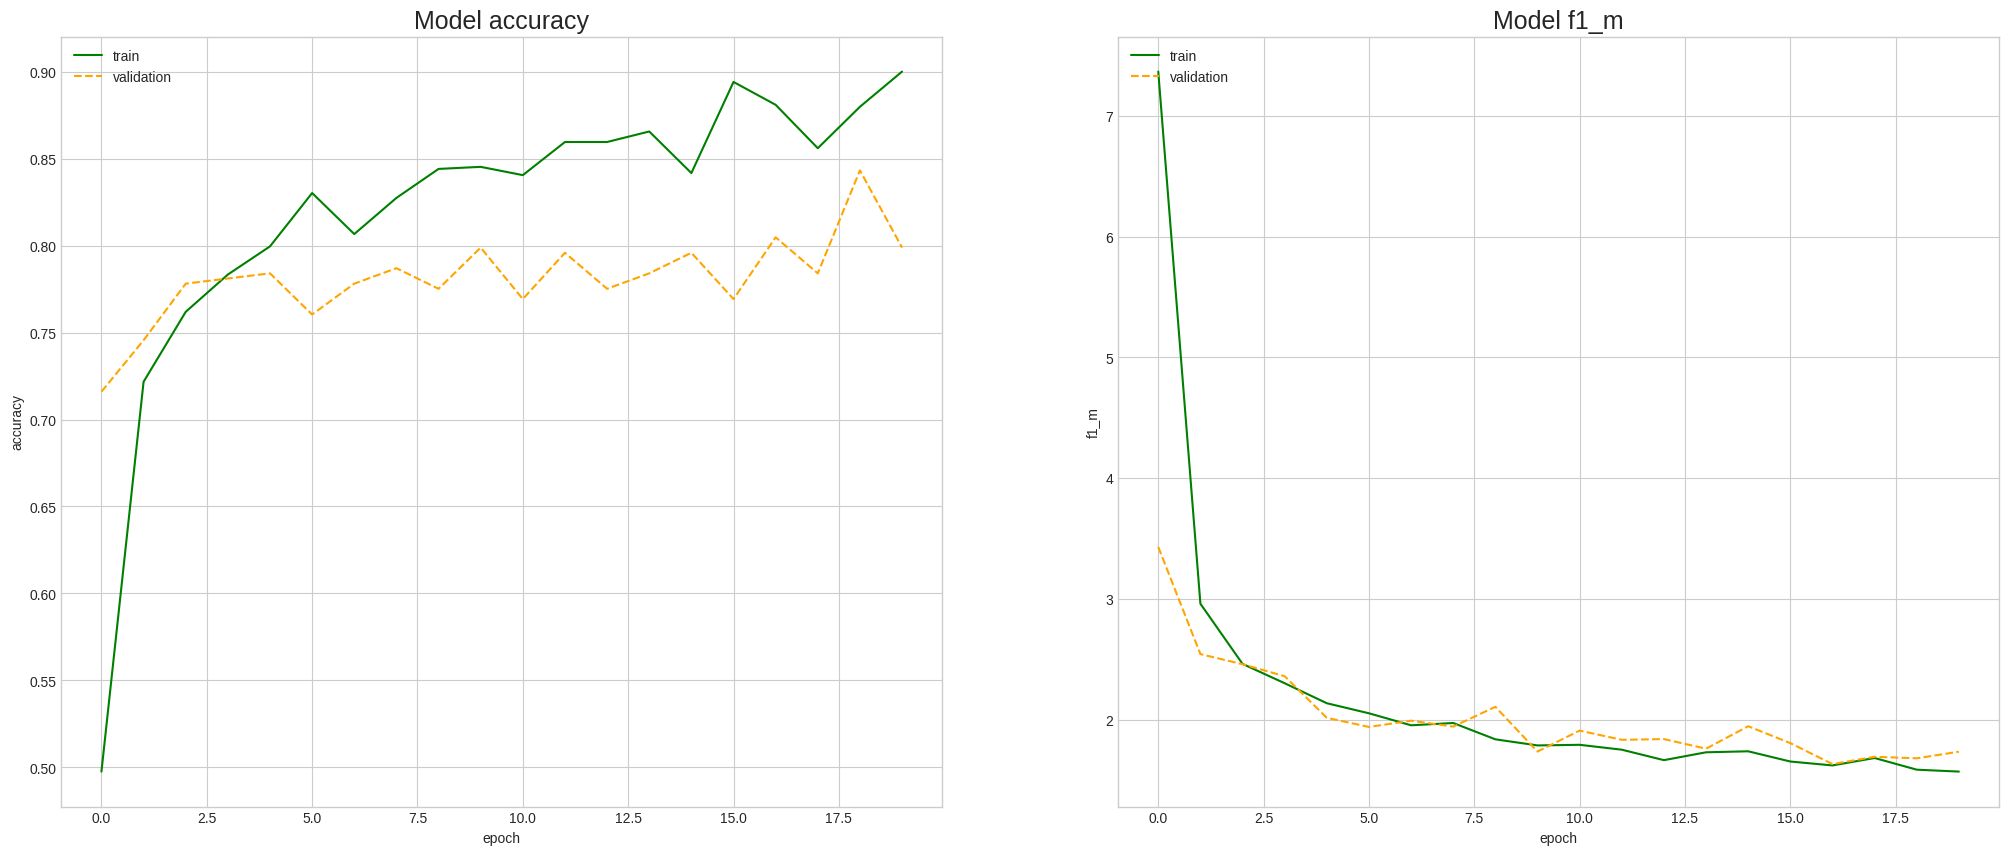

In [70]:
plot_history_scores(
    dict_history = history_xcept,
    first_score = "accuracy",
    second_score = "f1_m")

On voit nettement que le modèle Xception présente de meilleures performances que le modèle from scratch. En effet, le modèle apprend très vite et l'accuracy augmente rapidement, tout comme la perte diminue.

Effectuons une comparaison graphique des deux modèles.

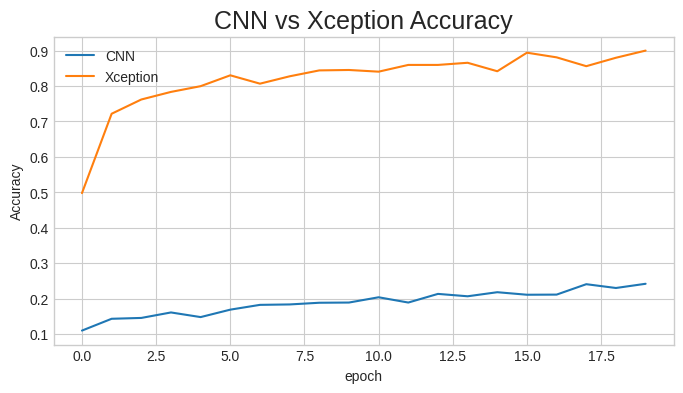

In [72]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['accuracy'],
             label='CNN')
    plt.plot(history_xcept.history['accuracy'],
             label='Xception')
    plt.title('CNN vs Xception Accuracy',
              fontsize=18)
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()

**On voit netttement que le transfert learning avec Xception présente de meilleurs résultats.**

In [73]:
logger.info("Xception base model validation Scores :")
logger.info("Mean validation accuracy: {:.2f}"\
      .format(np.mean(history_xcept.history['val_accuracy'])))
logger.info("Mean validation F1 score: {:.2f}"\
      .format(np.mean(history_xcept.history['val_f1_m'])))

2023-08-22 15:51:49.586 | INFO     | __main__:<cell line: 1>:1 - Xception base model validation Scores :
2023-08-22 15:51:49.588 | INFO     | __main__:<cell line: 2>:2 - Mean validation accuracy: 0.78
2023-08-22 15:51:49.591 | INFO     | __main__:<cell line: 4>:4 - Mean validation F1 score: 2.02


**Tranfert learning with RestNet**: L'idée clé derrière ResNet est l'utilisation de blocs résiduels. Ces blocs permettent au réseau d'apprendre des transformations résiduelles, c'est-à-dire les différences entre les caractéristiques d'entrée et de sortie d'une couche. Cela évite le problème de la disparition des gradients et facilite l'entraînement de réseaux très profonds.

  En utilisant ce mécanisme de blocs résiduels, ResNet peut être construit avec des centaines de couches tout en évitant les problèmes d'apprentissage profond. Cela a conduit à des améliorations significatives dans la précision des modèles de classification d'images et d'autres tâches de vision par ordinateur.

In [74]:
K.clear_session()
# Import ResNet50 trained model
resnet_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    pooling='avg',
    input_shape=(299,299,3))

# Dont retrain layers
for rn_layer in resnet_model.layers:
    rn_layer.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


In [75]:
# Add new fully-connected layers
rn_base_output = resnet_model.output
rn_base_output = Dense(128, activation='relu')(rn_base_output)
rn_base_output = Dropout(0.2)(rn_base_output)
# Output : new classifier
rn_predictions = Dense(num_breeds, activation='softmax')(rn_base_output)

# Define new model
my_resnet_model = Model(inputs=resnet_model.input,
                        outputs=rn_predictions)
my_resnet_model.compile(optimizer="adam",
                       loss="sparse_categorical_crossentropy",
                       metrics=["accuracy", f1_m])

In [76]:
# Data generator on train set with Data Augmentation
# Validation set is define here
rn_train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function=tf.keras.applications.resnet.preprocess_input)

#For validation and test, just rescale
rn_test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input)

In [77]:
history_resnet = my_resnet_model.fit(
    rn_train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'),
    validation_data=rn_train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    steps_per_epoch=len(x_train) / 32,
    epochs=20,
    verbose=2)

Epoch 1/20
52/52 - 33s - loss: 2.3657 - accuracy: 0.2702 - f1_m: 8.5037 - val_loss: 1.7792 - val_accuracy: 0.4822 - val_f1_m: 7.9039 - 33s/epoch - 622ms/step
Epoch 2/20
52/52 - 26s - loss: 1.5525 - accuracy: 0.4917 - f1_m: 5.7305 - val_loss: 1.2489 - val_accuracy: 0.6302 - val_f1_m: 5.1839 - 26s/epoch - 500ms/step
Epoch 3/20
52/52 - 27s - loss: 1.2313 - accuracy: 0.6132 - f1_m: 4.1142 - val_loss: 1.1666 - val_accuracy: 0.6420 - val_f1_m: 4.5579 - 27s/epoch - 507ms/step
Epoch 4/20
52/52 - 24s - loss: 1.1268 - accuracy: 0.6583 - f1_m: 3.7673 - val_loss: 1.0199 - val_accuracy: 0.6982 - val_f1_m: 3.7540 - 24s/epoch - 464ms/step
Epoch 5/20
52/52 - 26s - loss: 0.9205 - accuracy: 0.7036 - f1_m: 3.0902 - val_loss: 0.9741 - val_accuracy: 0.6686 - val_f1_m: 2.9877 - 26s/epoch - 500ms/step
Epoch 6/20
52/52 - 27s - loss: 0.8513 - accuracy: 0.7241 - f1_m: 2.7761 - val_loss: 0.9226 - val_accuracy: 0.6953 - val_f1_m: 2.7917 - 27s/epoch - 506ms/step
Epoch 7/20
52/52 - 26s - loss: 0.7646 - accuracy: 0.

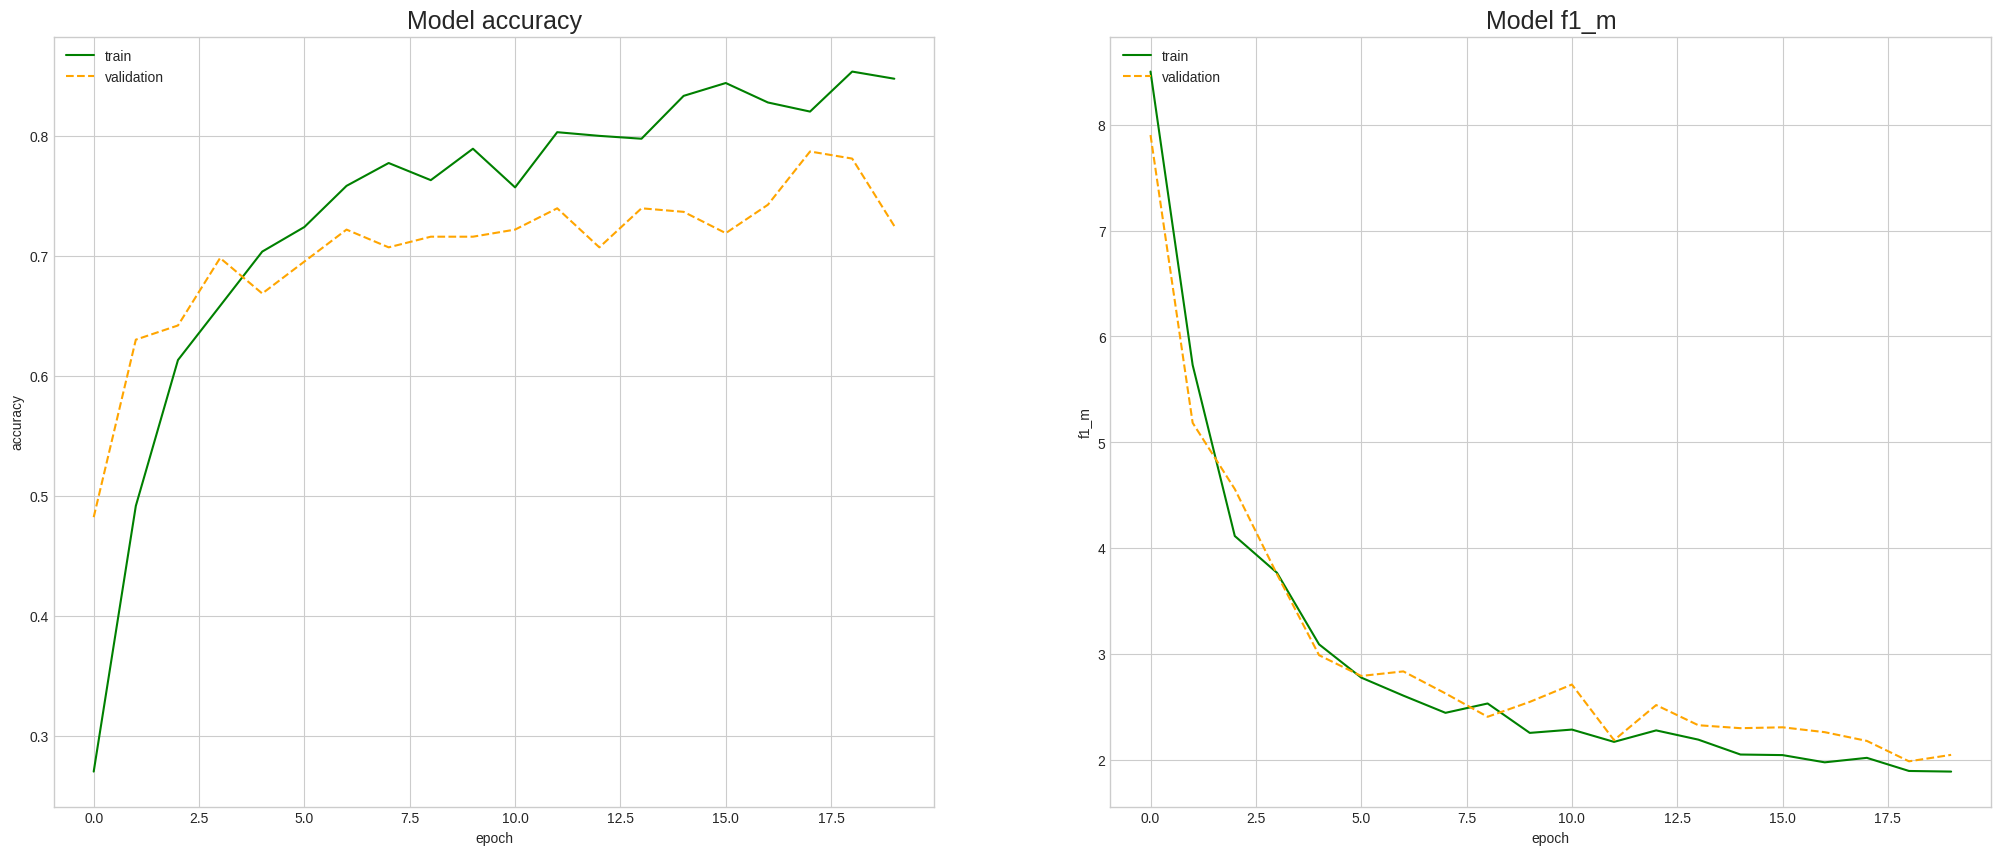

In [78]:
plot_history_scores(
    dict_history = history_resnet,
    first_score = "accuracy",
    second_score = "f1_m")

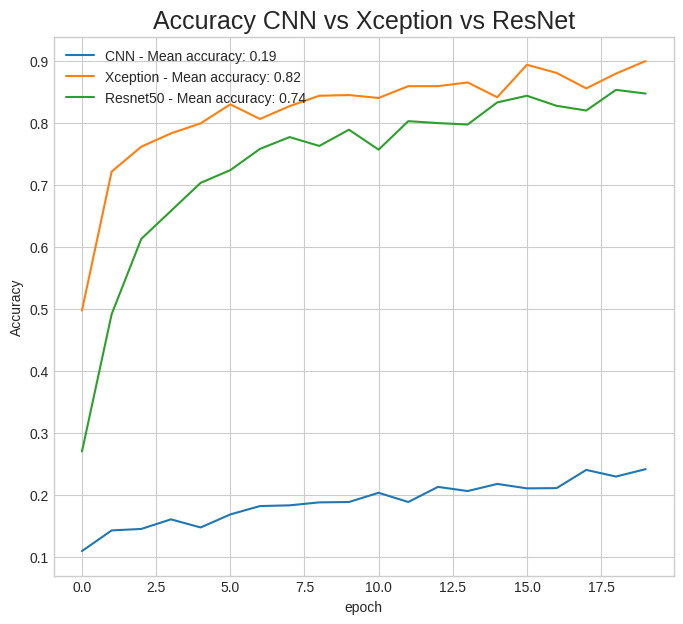

In [79]:
# compare models
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(8,7))
    plt.plot(history.history['accuracy'],
             label='CNN - Mean accuracy: {:.2f}'.format(
                 np.mean(history.history['accuracy'])))
    plt.plot(history_xcept.history['accuracy'],
             label='Xception - Mean accuracy: {:.2f}'.format(
                 np.mean(history_xcept.history['accuracy'])))
    plt.plot(history_resnet.history['accuracy'],
             label='Resnet50 - Mean accuracy: {:.2f}'.format(
                 np.mean(history_resnet.history['accuracy'])))
    plt.title('Accuracy CNN vs Xception vs ResNet',
              fontsize=18)
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()

On vient de tester trois modèles différents sans optimisations des paramètres. Et on constate que le modèle pré-entrainé Xception présente largement de meilleures performances.

Ainsi, on va continuer le travail avec ce modèle.

**Optimisation des paramètres sur la couche classifier du modèle Xception.**

Dans cette section, nous allons utiliser **kerastuner** pour améliorer les paramètres de la couche qu'on a ajoutée au modèle Xception.

Keras Tuner est une bibliothèque open-source développée par TensorFlow qui facilite l'optimisation des hyperparamètres de modèles de réseaux neuronaux. Elle permet d'automatiser le processus de recherche des meilleures combinaisons d'hyperparamètres pour améliorer les performances du modèle.

Keras Tuner propose différentes méthodes d'optimisation pour rechercher les hyperparamètres, telles que RandomSearch, Hyperband et Bayesian Optimization. Ces méthodes aident à explorer l'espace des hyperparamètres de manière efficace, afin de trouver les paramètres qui donnent les meilleures performances sur l'ensemble de validation.

Dans notre cas c'est RandomSearch qui est utilisé.

In [83]:
def model_builder(hp):
    # Load base model
    xception_model = tf.keras.applications.xception.Xception(
        weights='imagenet',
        include_top=False,
        pooling='avg',
        input_shape=(299, 299, 3))

    for layer in xception_model.layers:
        layer.trainable = False

    base_output = xception_model.output

    # Tune dense units
    #hp_units = hp.suggest_int('dense_units',32,  # min_value
     #                        300, # max_value
      #                       step=32 # step
      #                       )

    hp_units = hp.Int('dense_units',
                      min_value=32,
                      max_value=300,
                      step=32,
                      default=128)


    base_output = tf.keras.layers.Dense(units=hp_units, activation='relu')(base_output)
    base_output = tf.keras.layers.Dropout(0.2)(base_output)

    # Output: new classifier with our data
    predictions = tf.keras.layers.Dense(num_breeds, activation='softmax')(base_output)

    # Define new model
    my_xcept_model = tf.keras.Model(inputs=xception_model.input, outputs=predictions)

    # Tune learning rate
    #hp_learning_rate = hp.suggest_float('lr', 1e-4, 1e-2, log=True)
    hp_learning_rate = hp.Choice(
        name='learning_rate',
        values=[1e-2, 1e-3, 1e-4])

    my_xcept_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy", f1_m])

    return my_xcept_model

In [84]:
# Tune the learning rate for the optimizer
# Constuct the tuner of kerastuner
tuner = kt.RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=5)

# Define a early stopping
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5)

# Search best params
tuner.search(
    train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'),
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    epochs=10,
    callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("-" * 50)
print("Xception Hyperparameters optimization :")
print("-" * 50)
print(f"""
Best learning rate : {best_hps.get('learning_rate')}.\n
Best Dense units : {best_hps.get('dense_units')}.""")

--------------------------------------------------
Xception Hyperparameters optimization :
--------------------------------------------------

Best learning rate : 0.0001.

Best Dense units : 64.


**Avec un learning rate de 0.0001 et un un nombre de neuronnes dans les couches fully-connected de 64, on atteint les meilleures performances du modèle.**

Optimisation des hyperparametres du modèle Xception avec **optuna**.

In [43]:
def objective(trial):
    model = model_builder(trial)

    history = model.fit(
        train_datagen.flow(
            x_train, y_train,
            batch_size=16,
            subset='training'),
        validation_data=train_datagen.flow(
            x_train, y_train,
            batch_size=16,
            subset='validation'),
        epochs=10,
        verbose=2)
    return history.history['val_accuracy'][-1]

In [ ]:
# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective, n_trials=5)

# Print the best trial's parameters and values
best_trial = study.best_trial
print("Best trial:")
print("Value: ", best_trial.value)
print("Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-08-21 21:44:46,449] A new study created in memory with name: no-name-f4d0d75a-2862-424d-967f-fba7cf8630a9


Epoch 1/10
103/103 - 69s - loss: 1.2662 - accuracy: 0.6412 - f1_m: 2.9495 - val_loss: 0.7315 - val_accuracy: 0.7567 - val_f1_m: 2.2888 - 69s/epoch - 667ms/step
Epoch 2/10
103/103 - 68s - loss: 0.7955 - accuracy: 0.7492 - f1_m: 2.0135 - val_loss: 0.7565 - val_accuracy: 0.7640 - val_f1_m: 2.1058 - 68s/epoch - 662ms/step
Epoch 3/10
103/103 - 63s - loss: 0.7602 - accuracy: 0.7590 - f1_m: 2.0352 - val_loss: 0.6915 - val_accuracy: 0.7932 - val_f1_m: 2.1345 - 63s/epoch - 611ms/step
Epoch 4/10
103/103 - 65s - loss: 0.7405 - accuracy: 0.7772 - f1_m: 1.9078 - val_loss: 0.8001 - val_accuracy: 0.7397 - val_f1_m: 2.1325 - 65s/epoch - 634ms/step
Epoch 5/10
103/103 - 61s - loss: 0.6611 - accuracy: 0.7942 - f1_m: 1.7963 - val_loss: 0.6839 - val_accuracy: 0.7932 - val_f1_m: 1.7778 - 61s/epoch - 590ms/step
Epoch 6/10
103/103 - 64s - loss: 0.6688 - accuracy: 0.7869 - f1_m: 1.8010 - val_loss: 0.7234 - val_accuracy: 0.7664 - val_f1_m: 1.9790 - 64s/epoch - 619ms/step
Epoch 7/10
103/103 - 55s - loss: 0.6820 

[I 2023-08-21 21:56:58,220] Trial 0 finished with value: 0.8004866242408752 and parameters: {'dense_units': 288, 'lr': 0.0062257316584572505}. Best is trial 0 with value: 0.8004866242408752.


Epoch 1/10
103/103 - 59s - loss: 1.2471 - accuracy: 0.6315 - f1_m: 2.9885 - val_loss: 0.7903 - val_accuracy: 0.7786 - val_f1_m: 2.2205 - 59s/epoch - 571ms/step
Epoch 2/10
103/103 - 53s - loss: 0.7871 - accuracy: 0.7547 - f1_m: 2.0534 - val_loss: 0.7240 - val_accuracy: 0.7883 - val_f1_m: 2.0405 - 53s/epoch - 518ms/step
Epoch 3/10
103/103 - 64s - loss: 0.6682 - accuracy: 0.7954 - f1_m: 1.9046 - val_loss: 0.6263 - val_accuracy: 0.7932 - val_f1_m: 1.9207 - 64s/epoch - 618ms/step
Epoch 4/10
103/103 - 64s - loss: 0.6758 - accuracy: 0.7881 - f1_m: 1.7775 - val_loss: 0.7886 - val_accuracy: 0.7445 - val_f1_m: 1.9599 - 64s/epoch - 620ms/step
Epoch 5/10
103/103 - 56s - loss: 0.6447 - accuracy: 0.8148 - f1_m: 1.7787 - val_loss: 0.7814 - val_accuracy: 0.7810 - val_f1_m: 1.7348 - 56s/epoch - 540ms/step
Epoch 6/10
103/103 - 63s - loss: 0.5969 - accuracy: 0.8130 - f1_m: 1.7762 - val_loss: 0.6622 - val_accuracy: 0.8078 - val_f1_m: 1.7459 - 63s/epoch - 613ms/step
Epoch 7/10
103/103 - 56s - loss: 0.5752 

[I 2023-08-21 22:08:53,992] Trial 1 finished with value: 0.7810218930244446 and parameters: {'dense_units': 224, 'lr': 0.0051684632815993635}. Best is trial 0 with value: 0.8004866242408752.


Epoch 1/10
103/103 - 61s - loss: 1.1368 - accuracy: 0.6582 - f1_m: 3.5065 - val_loss: 0.6441 - val_accuracy: 0.7835 - val_f1_m: 2.1088 - 61s/epoch - 594ms/step
Epoch 2/10
103/103 - 50s - loss: 0.6595 - accuracy: 0.7990 - f1_m: 1.9668 - val_loss: 0.6481 - val_accuracy: 0.7835 - val_f1_m: 1.9006 - 50s/epoch - 490ms/step
Epoch 3/10
103/103 - 51s - loss: 0.6418 - accuracy: 0.8021 - f1_m: 1.8645 - val_loss: 0.7166 - val_accuracy: 0.7956 - val_f1_m: 1.8350 - 51s/epoch - 497ms/step
Epoch 4/10
103/103 - 52s - loss: 0.5809 - accuracy: 0.8106 - f1_m: 1.7837 - val_loss: 0.6044 - val_accuracy: 0.8078 - val_f1_m: 1.8887 - 52s/epoch - 504ms/step
Epoch 5/10
103/103 - 51s - loss: 0.5459 - accuracy: 0.8251 - f1_m: 1.7757 - val_loss: 0.6423 - val_accuracy: 0.7932 - val_f1_m: 1.8692 - 51s/epoch - 496ms/step
Epoch 6/10
103/103 - 53s - loss: 0.4949 - accuracy: 0.8409 - f1_m: 1.7029 - val_loss: 0.6466 - val_accuracy: 0.8102 - val_f1_m: 1.6796 - 53s/epoch - 519ms/step
Epoch 7/10
103/103 - 54s - loss: 0.4909 

[I 2023-08-21 22:21:11,884] Trial 2 finished with value: 0.7810218930244446 and parameters: {'dense_units': 192, 'lr': 0.0025113110466755467}. Best is trial 0 with value: 0.8004866242408752.


Epoch 1/10
103/103 - 57s - loss: 1.3483 - accuracy: 0.6205 - f1_m: 3.4861 - val_loss: 0.7486 - val_accuracy: 0.7616 - val_f1_m: 2.2400 - 57s/epoch - 558ms/step
Epoch 2/10
103/103 - 63s - loss: 0.8764 - accuracy: 0.7359 - f1_m: 2.3038 - val_loss: 0.7753 - val_accuracy: 0.7689 - val_f1_m: 2.0186 - 63s/epoch - 609ms/step
Epoch 3/10
103/103 - 58s - loss: 0.7850 - accuracy: 0.7626 - f1_m: 2.0223 - val_loss: 0.8029 - val_accuracy: 0.7421 - val_f1_m: 2.3025 - 58s/epoch - 560ms/step
Epoch 4/10
103/103 - 53s - loss: 0.7253 - accuracy: 0.7790 - f1_m: 1.8848 - val_loss: 0.7918 - val_accuracy: 0.7518 - val_f1_m: 1.8314 - 53s/epoch - 511ms/step
Epoch 5/10
103/103 - 53s - loss: 0.7204 - accuracy: 0.7772 - f1_m: 1.9297 - val_loss: 0.7828 - val_accuracy: 0.7494 - val_f1_m: 2.0454 - 53s/epoch - 518ms/step
Epoch 6/10
103/103 - 64s - loss: 0.7771 - accuracy: 0.7626 - f1_m: 1.9407 - val_loss: 0.6744 - val_accuracy: 0.7908 - val_f1_m: 2.0399 - 64s/epoch - 622ms/step
Epoch 7/10
103/103 - 64s - loss: 0.6787 

[I 2023-08-21 22:32:15,891] Trial 3 finished with value: 0.7639902830123901 and parameters: {'dense_units': 192, 'lr': 0.007928598393379064}. Best is trial 0 with value: 0.8004866242408752.


Epoch 1/10
103/103 - 67s - loss: 1.9445 - accuracy: 0.4791 - f1_m: 9.9580 - val_loss: 1.1901 - val_accuracy: 0.7543 - val_f1_m: 5.4856 - 67s/epoch - 651ms/step
Epoch 2/10
103/103 - 63s - loss: 1.0667 - accuracy: 0.7353 - f1_m: 4.2341 - val_loss: 0.8591 - val_accuracy: 0.8029 - val_f1_m: 3.4605 - 63s/epoch - 614ms/step
Epoch 3/10
103/103 - 52s - loss: 0.8220 - accuracy: 0.7735 - f1_m: 2.9774 - val_loss: 0.7354 - val_accuracy: 0.7762 - val_f1_m: 2.8158 - 52s/epoch - 502ms/step
Epoch 4/10
103/103 - 51s - loss: 0.7116 - accuracy: 0.7911 - f1_m: 2.5979 - val_loss: 0.6630 - val_accuracy: 0.8029 - val_f1_m: 2.3426 - 51s/epoch - 498ms/step
Epoch 5/10
103/103 - 66s - loss: 0.6733 - accuracy: 0.7984 - f1_m: 2.4188 - val_loss: 0.6703 - val_accuracy: 0.7956 - val_f1_m: 2.2105 - 66s/epoch - 638ms/step
Epoch 6/10
103/103 - 53s - loss: 0.6588 - accuracy: 0.8033 - f1_m: 2.3097 - val_loss: 0.5702 - val_accuracy: 0.8321 - val_f1_m: 2.0753 - 53s/epoch - 514ms/step
Epoch 7/10
103/103 - 54s - loss: 0.5760 

[I 2023-08-21 22:44:10,183] Trial 4 finished with value: 0.812652051448822 and parameters: {'dense_units': 64, 'lr': 0.00033947676751815966}. Best is trial 4 with value: 0.812652051448822.


Best trial:
Value:  0.812652051448822
Params: 
    dense_units: 64
    lr: 0.00033947676751815966


In [ ]:
# Get the best hyperparameters from the Optuna study
best_params = study.best_params
logger.info(best_params)

2023-08-21 22:49:16.402 | INFO     | __main__:<cell line: 3>:3 - {'dense_units': 64, 'lr': 0.00033947676751815966}


**Re-entrainement du modèle avec les meilleurs paramètres**

- avec keras_tuner

In [85]:
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(
    train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'),
    epochs=30,
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    verbose=2)

Epoch 1/30
85/85 - 43s - loss: 2.5261 - accuracy: 0.2478 - f1_m: 13.7940 - val_loss: 2.2727 - val_accuracy: 0.4675 - val_f1_m: 13.7339 - 43s/epoch - 503ms/step
Epoch 2/30
85/85 - 40s - loss: 2.0433 - accuracy: 0.5007 - f1_m: 11.3213 - val_loss: 1.7855 - val_accuracy: 0.6538 - val_f1_m: 9.9173 - 40s/epoch - 474ms/step
Epoch 3/30
85/85 - 37s - loss: 1.6446 - accuracy: 0.6243 - f1_m: 8.6024 - val_loss: 1.4880 - val_accuracy: 0.7249 - val_f1_m: 7.9459 - 37s/epoch - 435ms/step
Epoch 4/30
85/85 - 39s - loss: 1.3930 - accuracy: 0.6701 - f1_m: 6.4702 - val_loss: 1.2126 - val_accuracy: 0.7574 - val_f1_m: 5.8881 - 39s/epoch - 461ms/step
Epoch 5/30
85/85 - 40s - loss: 1.2230 - accuracy: 0.6827 - f1_m: 5.1233 - val_loss: 1.1111 - val_accuracy: 0.7515 - val_f1_m: 4.9213 - 40s/epoch - 472ms/step
Epoch 6/30
85/85 - 40s - loss: 1.1256 - accuracy: 0.6975 - f1_m: 4.4469 - val_loss: 0.9997 - val_accuracy: 0.7456 - val_f1_m: 4.0772 - 40s/epoch - 472ms/step
Epoch 7/30
85/85 - 39s - loss: 1.0183 - accuracy:

In [86]:
hypermodel.save(os.path.join(MODEL_DIR,MODEL_NAME))
print("Model saved")

Model saved


**Xception fine tuning**

le "fine-tuning" est une stratégie permettant d'utiliser un modèle pré-entraîné comme point de départ pour résoudre une tâche spécifique en ajustant les dernières couches du modèle à partir de nouvelles données. Cela permet d'économiser du temps et des ressources par rapport à l'entraînement à partir de zéro, tout en exploitant les connaissances apprises par le modèle pré-entraîné.
Dans Xception on a trois blocs: le flux, d'entrée, le flux moyen et le flux de sortie.

Après avoir optimisé les paramètres de notre modèle Xception, nous nous concentrons sur l'amélioration spécifique de la dernière partie du modèle qui prend des décisions finales. Plutôt que de tout réentraîner, nous ajustons cette partie cruciale pour s'adapter à notre tâche, en utilisant les paramètres optimisés pour obtenir de meilleures performances. Cela nous permet d'exploiter les améliorations tout en ciblant la partie essentielle du modèle pour notre objectif.

In [44]:
def xception_fine_tune(nb_layers):
    # Load the pre-trained model
    hypermodel_t = load_model(os.path.join(MODEL_DIR,'20230821_model_stanford_breed_dogs.h5'), custom_objects={"f1_m": f1_m})

    # Freeze or unfreeze layers based on the given number
    for i, layer in enumerate(hypermodel_t.layers):
        layer.trainable = i >= nb_layers
    # Compile model
    hypermodel_t.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy", f1_m])

    return hypermodel_t

In [104]:
# Define a early stopping
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5)

# Dont train the 115 first layers
my_tuned_xcept_model = xception_fine_tune(115)
fine_tuned_history = my_tuned_xcept_model.fit(
    train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        shuffle=False,
        subset='training'),
    epochs=20,
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        shuffle=False,
        subset='validation'),
    callbacks=[stop_early],
    verbose=2)

Epoch 1/20
85/85 - 47s - loss: 1.3719 - accuracy: 0.5954 - f1_m: 3.8061 - val_loss: 1.6205 - val_accuracy: 0.6538 - val_f1_m: 1.7175 - 47s/epoch - 551ms/step
Epoch 2/20
85/85 - 40s - loss: 0.7185 - accuracy: 0.7796 - f1_m: 2.0511 - val_loss: 1.4965 - val_accuracy: 0.6509 - val_f1_m: 1.4726 - 40s/epoch - 475ms/step
Epoch 3/20
85/85 - 42s - loss: 0.5366 - accuracy: 0.8203 - f1_m: 1.7403 - val_loss: 1.2092 - val_accuracy: 0.7071 - val_f1_m: 1.5587 - 42s/epoch - 490ms/step
Epoch 4/20
85/85 - 40s - loss: 0.4165 - accuracy: 0.8654 - f1_m: 1.5216 - val_loss: 1.0254 - val_accuracy: 0.7456 - val_f1_m: 1.5064 - 40s/epoch - 468ms/step
Epoch 5/20
85/85 - 40s - loss: 0.3612 - accuracy: 0.8883 - f1_m: 1.4525 - val_loss: 1.6431 - val_accuracy: 0.6923 - val_f1_m: 1.4387 - 40s/epoch - 467ms/step
Epoch 6/20
85/85 - 40s - loss: 0.3013 - accuracy: 0.9083 - f1_m: 1.3799 - val_loss: 1.1002 - val_accuracy: 0.7633 - val_f1_m: 1.3847 - 40s/epoch - 472ms/step
Epoch 7/20
85/85 - 38s - loss: 0.2446 - accuracy: 0.

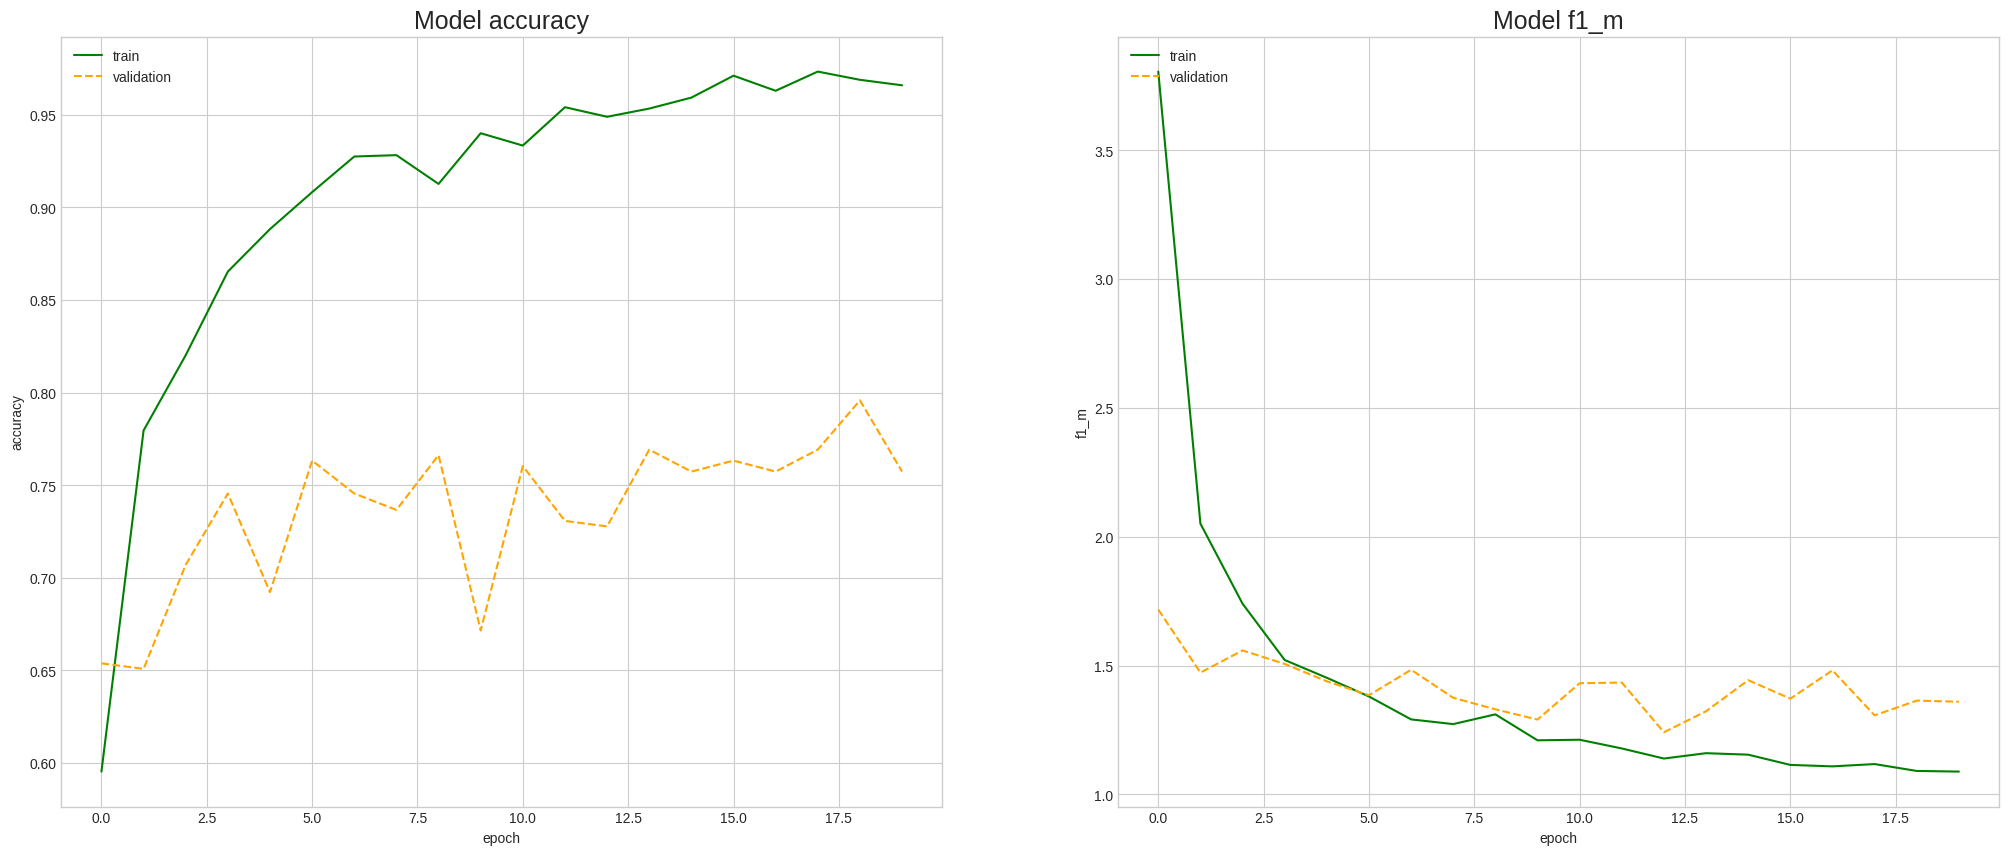

In [105]:
plot_history_scores(
    dict_history = fine_tuned_history,
    first_score = "accuracy",
    second_score = "f1_m")

On peut nettement voir que l'acccuracy a atteint jusqu’à 90% lors de l'entrainement et que le f1-score n'est pas élévé.

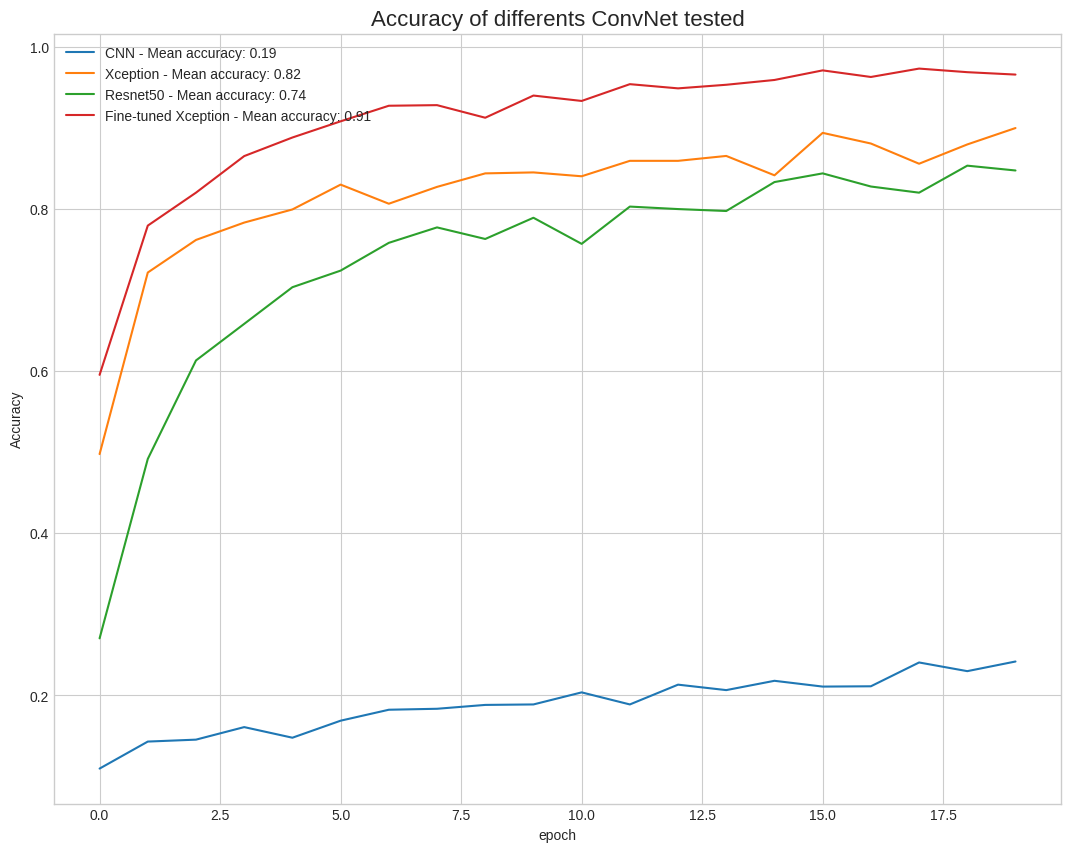

In [106]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(13,10))
    plt.plot(history.history['accuracy'],
             label='CNN - Mean accuracy: {:.2f}'.format(
                 np.mean(history.history['accuracy'])))
    plt.plot(history_xcept.history['accuracy'],
             label='Xception - Mean accuracy: {:.2f}'.format(
                 np.mean(history_xcept.history['accuracy'])))
    plt.plot(history_resnet.history['accuracy'],
             label='Resnet50 - Mean accuracy: {:.2f}'.format(
                 np.mean(history_resnet.history['accuracy'])))
    plt.plot(fine_tuned_history.history['accuracy'],
             label='Fine-tuned Xception - Mean accuracy: {:.2f}'.format(
                 np.mean(fine_tuned_history.history['accuracy'])))
    plt.title('Accuracy of differents ConvNet tested',
              fontsize=16)
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()

**Evaluation du modèle Xception fine tuning**

In [107]:
# Model evaluation on test set
xception_eval = fine_tuned_history.model.evaluate(
    test_datagen.flow(
        x_test, y_test,
        batch_size=16,
        shuffle=False),
    verbose=1)
logger.info("Xception model evaluation :")
logger.info('Test Loss: {:.3f}'.format(xception_eval[0]))
logger.info('Test Accuracy: {:.3f}'.format(xception_eval[1]))
logger.info('Test F1 score: {:.3f}'.format(xception_eval[2]))

27/27 [==============================] - 3s 118ms/step - loss: 1.5629 - accuracy: 0.7589 - f1_m: 1.2525


2023-08-22 17:10:41.180 | INFO     | __main__:<cell line: 8>:8 - Xception model evaluation :
2023-08-22 17:10:41.182 | INFO     | __main__:<cell line: 9>:9 - Test Loss: 1.563
2023-08-22 17:10:41.185 | INFO     | __main__:<cell line: 10>:10 - Test Accuracy: 0.759
2023-08-22 17:10:41.186 | INFO     | __main__:<cell line: 11>:11 - Test F1 score: 1.253


Le modèle Xception Fine Tuned présente une accuracy de **75.9%** sur les données tests

Observons un peu le rapport de classification sur les données prédites.

In [91]:
# Make predictions
Y_pred = fine_tuned_history.model.predict(
    test_datagen.flow(
        x_test, y_test,
        batch_size=16,
        shuffle=False))
y_pred = np.argmax(Y_pred, axis=1)

# Inverse encoding
y_pred_s = encoder.inverse_transform(y_pred)
y_test_s = encoder.inverse_transform(y_test)

27/27 [==============================] - 4s 118ms/step


In [94]:
# Classification report
logger.info("\n{}",classification_report(
    y_test, y_pred,
    target_names=sorted(set(y_test_s))))

2023-08-22 16:36:49.039 | INFO     | __main__:<cell line: 2>:2 - 
                            precision    recall  f1-score   support

         Brabancon_griffon       1.00      0.93      0.96        14
Greater_Swiss_Mountain_dog       0.76      0.95      0.84        20
              Ibizan_hound       0.50      0.96      0.66        27
        Kerry_blue_terrier       0.97      0.73      0.84        49
          Lakeland_terrier       0.93      0.50      0.65        26
              Newfoundland       0.67      0.73      0.70        11
                Rottweiler       0.93      0.89      0.91        28
                    Saluki       0.96      0.73      0.83        37
         Shetland_sheepdog       0.91      0.91      0.91        23
                      Shih       0.89      0.95      0.92        41
            Siberian_husky       0.76      0.64      0.70        25
                  malamute       0.86      0.52      0.65        23
                otterhound       1.00      0.74  

Le rapport de classification nous indiquent que les résultats sont satisfaisants. En effet, **l'accuracy globale sur le jeu de test est de 80%**.

A présent, nous allons visualiser quelques-unes de ces prédictions avec leurs labels :

**Comportement du modèle sur quelques images choisies aléatoirement**

In [97]:
fig = plt.figure(1, figsize=(18, 18))
fig.patch.set_facecolor('#343434')
plt.suptitle("Predicted VS actual for Xception model fine-tuned",
             y=0.92, fontsize=22, color="white")

num_rows = 3
num_cols = 4
random_indices = np.random.randint(0, x_test.shape[0], num_rows * num_cols)

for n, r in enumerate(random_indices, start=1):
    plt.subplot(num_rows, num_cols, n)
    plt.subplots_adjust(hspace=0.4, wspace=0.1)
    plt.imshow(array_to_img(x_test[r]))
    plt.title('Actual = {}\nPredicted = {}'.format(y_test_s[r], y_pred_s[r]),
              color="white")
    plt.xticks([]), plt.yticks([])

plt.show()

Output hidden; open in https://colab.research.google.com to view.

On peut bien voir que notre modèle prédit de manière satisfaisante les données.

**Save final model**

In [98]:
# Save the last model
fine_tuned_history.model.save(os.path.join(MODEL_DIR,MODEL_NAME))
print("Last model saved")

Last model saved


**Tracking avec Mlflow**

In [112]:
# Set the artifact location in the MLflow configuration
artifact_location = os.path.join(REPORT_DIR,"mlflow_artifacts")
# Create an experiment if not exists
exp_name = "stanford-breed-dogs"
experiment = mlflow.get_experiment_by_name(exp_name)
if not experiment:
    experiment_id = mlflow.create_experiment(exp_name)
else:
    experiment_id = experiment.experiment_id


# Start an MLflow run
with mlflow.start_run(run_name=f"{EXECUTION_DATE.strftime('%Y%m%d_%H%m%S')}-standford-brees-dogs",
                      experiment_id=experiment_id,
                      tags={"version": "v1", "priority": "P1"},
                      description="house price modeling") as mlf_run:

    # Log parameters (if applicable)
    num_classes = 15
    img_width = 299
    img_height = 299

    # Log metrics (if applicable)
    mlflow.log_metric('final_train_loss', fine_tuned_history.history['loss'][-1])
    mlflow.log_metric('final_train_accuracy', fine_tuned_history.history['accuracy'][-1])

    # Save the fine-tuned model as an artifact
    mlflow.log_artifact(os.path.join(MODEL_DIR,'20230822_model_stanford_breed_dogs.h5'))

    # Log TensorFlow model using MLflow
    mlflow.tensorflow.log_model(fine_tuned_history.model, artifact_path='models')

# End the MLflow run
print("MLflow run completed with run_id:", mlf_run.info.run_id)

2023/08/22 17:17:31 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2023/08/22 17:18:04 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpp2uczzj2/model, flavor: tensorflow), fall back to return ['tensorflow==2.12.0']. Set logging level to DEBUG to see the full traceback.


MLflow run completed with run_id: c8a3773ae53345b48cacebe792a2a858


In [113]:
# Load environment variables from .env
load_dotenv()
ngrok_auth_token = os.getenv("NGROK_AUTH_TOKEN")
ngrok.set_auth_token(ngrok_auth_token)
# Start an ngrok tunnel to the MLflow UI port (default is 5000)
public_url = ngrok.connect(addr="5000")
# Print the public URL of the tunnel
print("MLflow UI:", public_url)

MLflow UI: NgrokTunnel: "https://b8aa-34-168-232-242.ngrok-free.app" -> "http://localhost:5000"


In [114]:
!mlflow ui --host "localhost"  --port 5000

[2023-08-22 17:18:39 +0000] [46072] [INFO] Starting gunicorn 21.2.0
[2023-08-22 17:18:39 +0000] [46072] [INFO] Listening at: http://127.0.0.1:5000 (46072)
[2023-08-22 17:18:39 +0000] [46072] [INFO] Using worker: sync
[2023-08-22 17:18:39 +0000] [46077] [INFO] Booting worker with pid: 46077
[2023-08-22 17:18:39 +0000] [46078] [INFO] Booting worker with pid: 46078
[2023-08-22 17:18:39 +0000] [46079] [INFO] Booting worker with pid: 46079
[2023-08-22 17:18:39 +0000] [46080] [INFO] Booting worker with pid: 46080

[2023-08-22 17:21:56 +0000] [46072] [INFO] Handling signal: int
Aborted!
[2023-08-22 17:21:56 +0000] [46077] [INFO] Worker exiting (pid: 46077)
[2023-08-22 17:21:56 +0000] [46079] [INFO] Worker exiting (pid: 46079)
[2023-08-22 17:21:56 +0000] [46080] [INFO] Worker exiting (pid: 46080)
[2023-08-22 17:21:56 +0000] [46078] [INFO] Worker exiting (pid: 46078)
[2023-08-22 17:21:57 +0000] [46072] [INFO] Shutting down: Master


**Predictions**

In [141]:
# Load model
breed_model = load_model(os.path.join(MODEL_DIR,'20230822_model_stanford_breed_dogs.h5'), custom_objects={"f1_m": f1_m})

# Define the prediction function
def predict_breed(image_path):
    # Load and preprocess the image
    img = cv.imread(image_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    dim = (299, 299)
    img = cv.resize(img, dim, interpolation=cv.INTER_LINEAR)
    img_yuv = cv.cvtColor(img, cv.COLOR_BGR2YUV)
    img_yuv[:,:,0] = cv.equalizeHist(img_yuv[:,:,0])
    img_equ = cv.cvtColor(img_yuv, cv.COLOR_YUV2RGB)
    dst_img = cv.fastNlMeansDenoisingColored(
        src=img_equ,
        dst=None,
        h=10,
        hColor=10,
        templateWindowSize=7,
        searchWindowSize=21)
    img_array = keras.preprocessing.image.img_to_array(dst_img)
    img_array = img_array.reshape((-1, 299, 299, 3))
    img_array = tf.keras.applications.xception.preprocess_input(img_array)

    # Predict
    prediction = breed_model.predict(img_array)
    predicted_label_index = np.argmax(prediction)
    predicted_label = encoder.classes_[predicted_label_index]
    confidence = prediction[0][predicted_label_index]

    return predicted_label, confidence

In [142]:
img_test_to_pred = (images_dir
            + "/"
            + os.listdir(images_dir)[4]+"/"+os.listdir(images_dir+"/"+os.listdir(images_dir)[4])[0])
predicted_breed = predict_breed(img_test_to_pred)
print("Predicted Breed:", predicted_breed)

1/1 [==============================] - 1s 768ms/step
Predicted Breed: ('Shih', 0.9999999)


# End of the work